In [3]:
import pandas as pd
import numpy as np

#data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from warnings import filterwarnings
filterwarnings('ignore')

from datetime import datetime, date, timedelta
import mlxtend

#models libraries
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.plotting import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBRegressor, XGBClassifier

#Metrics 
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances
import sklearn.metrics as metrics
from scipy.spatial.distance import cosine, correlation

In [19]:
customer= pd.read_excel('CustomersData.xlsx')
discount= pd.read_csv('Discount_Coupon.csv')
marketing= pd.read_csv('Marketing_Spend.csv')
sales= pd.read_csv('Online_Sales.csv')
tax= pd.read_excel('Tax_amount.xlsx')

In [3]:
customer.head()

CustomerID Gender    Location  Tenure_Months
0       17850      M     Chicago             12
1       13047      M  California             43
2       12583      M     Chicago             33
3       13748      F  California             30
4       15100      M  California             49

In [4]:
discount.head()

Month Product_Category  Coupon_Code  Discount_pct
0   Jan           Apparel      SALE10            10
1   Feb           Apparel      SALE20            20
2   Mar           Apparel      SALE30            30
3   Jan          Nest-USA      ELEC10            10
4   Feb          Nest-USA      ELEC20            20

In [5]:
marketing.head()

Date  Offline_Spend  Online_Spend
0  1/1/2019           4500       2424.50
1  1/2/2019           4500       3480.36
2  1/3/2019           4500       1576.38
3  1/4/2019           4500       2928.55
4  1/5/2019           4500       4055.30

In [6]:
sales.head()

CustomerID  Transaction_ID  Transaction_Date     Product_SKU  \
0       17850           16679          20190101  GGOENEBJ079499   
1       17850           16680          20190101  GGOENEBJ079499   
2       17850           16681          20190101  GGOEGFKQ020399   
3       17850           16682          20190101  GGOEGAAB010516   
4       17850           16682          20190101  GGOEGBJL013999   

                                 Product_Description Product_Category  \
0  Nest Learning Thermostat 3rd Gen-USA - Stainle...         Nest-USA   
1  Nest Learning Thermostat 3rd Gen-USA - Stainle...         Nest-USA   
2              Google Laptop and Cell Phone Stickers           Office   
3  Google Men's 100% Cotton Short Sleeve Hero Tee...          Apparel   
4                    Google Canvas Tote Natural/Navy             Bags   

   Quantity  Avg_Price  Delivery_Charges Coupon_Status  
0         1     153.71               6.5          Used  
1         1     153.71               6.5          Used  
2         1       2.05               6.5          Used  
3         5      17.53               6.5      Not Used  
4         1      16.50               6.5          Used

In [7]:
tax.head()

Product_Category   GST
0         Nest-USA  0.10
1           Office  0.10
2          Apparel  0.18
3             Bags  0.18
4        Drinkware  0.18

In [20]:
customer.columns = customer.columns.str.strip()
discount.columns = discount.columns.str.strip()
marketing.columns = marketing.columns.str.strip()
sales.columns = sales.columns.str.strip()
tax.columns = tax.columns.str.strip()

sales['Product_Category'] = sales['Product_Category'].astype('str')
discount['Product_Category'] = discount['Product_Category'].astype('str')

In [21]:
#Changing format
sales['Transaction_Date'] = pd.to_datetime(sales['Transaction_Date'], format='%Y%m%d')

# Now you can use the .dt accessor
sales['Month'] = sales['Transaction_Date'].dt.month
sales['week']= sales['Transaction_Date'].dt.isocalendar().week
sales['day']= sales['Transaction_Date'].dt.day_name()
sales['Year']= sales['Transaction_Date'].dt.year

#'Transaction_Date' column formatted as 'YYYY-MM-DD' for display purposes
# converting it to string format after extracting the month
sales['Transaction_Date'] = pd.to_datetime(sales['Transaction_Date']).dt.strftime('%Y-%m-%d')

In [22]:
sales['Transaction_Date'] = pd.to_datetime(sales['Transaction_Date'], errors='coerce')

In [6]:
sales['Transaction_Date']

0       2019-01-01
1       2019-01-01
2       2019-01-01
3       2019-01-01
4       2019-01-01
           ...    
52919   2019-12-31
52920   2019-12-31
52921   2019-12-31
52922   2019-12-31
52923   2019-12-31
Name: Transaction_Date, Length: 52924, dtype: datetime64[ns]

In [23]:
#Changing format
marketing['Date'] = pd.to_datetime(marketing['Date'], format='%m/%d/%Y').dt.strftime('%Y-%m-%d')

In [24]:
marketing['Date'] = pd.to_datetime(marketing['Date'], errors='coerce')

In [9]:
marketing['Date']

0     2019-01-01
1     2019-01-02
2     2019-01-03
3     2019-01-04
4     2019-01-05
         ...    
360   2019-12-27
361   2019-12-28
362   2019-12-29
363   2019-12-30
364   2019-12-31
Name: Date, Length: 365, dtype: datetime64[ns]

In [25]:
# Combining online and offline marketing spend in one
marketing['Total_marketing_spend']= marketing['Offline_Spend']+marketing['Online_Spend']

In [26]:
# Changing type of month column from month name to month number
discount['Month']=pd.to_datetime(discount['Month'], format='%b')
discount['Month']=discount['Month'].dt.month

In [27]:
sales = sales.merge(discount, on=['Product_Category', 'Month'], how='left')
sales = sales.merge(tax, on='Product_Category', how='left')
sales = sales.merge(customer, on=['CustomerID'], how='left')
sales = sales.merge(marketing, left_on='Transaction_Date', right_on='Date', how='left')

In [13]:
sales.isna().sum()

CustomerID                 0
Transaction_ID             0
Transaction_Date           0
Product_SKU                0
Product_Description        0
Product_Category           0
Quantity                   0
Avg_Price                  0
Delivery_Charges           0
Coupon_Status              0
Month                      0
week                       0
day                        0
Year                       0
Coupon_Code              400
Discount_pct             400
GST                        0
Gender                     0
Location                   0
Tenure_Months              0
Date                       0
Offline_Spend              0
Online_Spend               0
Total_marketing_spend      0
dtype: int64

# 1.Calculating Invoice amount or sales_amount or revenue for each transaction and item level

In [28]:
# Calculating Invoice amount
sales['Invoice_amount']=((sales['Quantity']*sales['Avg_Price'])*(1-sales['Discount_pct']/100)*(1+sales['GST']))+sales['Delivery_Charges']

In [29]:
# For each transaction
sales.groupby(by='Transaction_ID')['Invoice_amount'].sum()

Transaction_ID
16679    158.67290
16680    158.67290
16681      8.52950
16682    785.85410
16684    336.76960
           ...    
48493     99.90100
48494     46.90792
48495    123.44760
48496    316.50200
48497    267.99160
Name: Invoice_amount, Length: 25061, dtype: float64

In [15]:
# For each product(Item Level)
sales.groupby(by='Product_SKU')['Invoice_amount'].sum()

Product_SKU
GGOEA0CH077599     6470.61085
GGOEAAAB034813      425.72510
GGOEAAAB034814      866.34704
GGOEAAAB034815      922.55824
GGOEAAAB034816      551.97818
                     ...     
GGOEYOCR077399     1908.45840
GGOEYOCR077799    19507.87200
GGOEYOCR078099     3621.70265
GGOEYOLR018699    10690.91760
GGOEYOLR080599     2292.85990
Name: Invoice_amount, Length: 1145, dtype: float64

# 1. EDA

• Understanding how many customers acquired every month

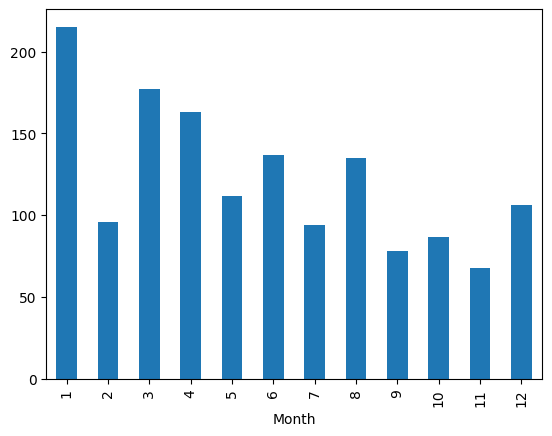

In [14]:
x=sales.drop_duplicates(subset=['CustomerID'], keep='first').groupby(by='Month').count()['CustomerID']
x.plot(kind='bar')
plt.show()

In [41]:
sales

CustomerID  Transaction_ID Transaction_Date     Product_SKU  \
0           17850           16679       2019-01-01  GGOENEBJ079499   
1           17850           16680       2019-01-01  GGOENEBJ079499   
2           17850           16681       2019-01-01  GGOEGFKQ020399   
3           17850           16682       2019-01-01  GGOEGAAB010516   
4           17850           16682       2019-01-01  GGOEGBJL013999   
...           ...             ...              ...             ...   
52919       14410           48493       2019-12-31  GGOENEBB078899   
52920       14410           48494       2019-12-31  GGOEGAEB091117   
52921       14410           48495       2019-12-31  GGOENEBQ084699   
52922       14600           48496       2019-12-31  GGOENEBQ079199   
52923       14600           48497       2019-12-31  GGOENEBQ079099   

                                     Product_Description Product_Category  \
0      Nest Learning Thermostat 3rd Gen-USA - Stainle...         Nest-USA   
1      Nest Learning Thermostat 3rd Gen-USA - Stainle...         Nest-USA   
2                  Google Laptop and Cell Phone Stickers           Office   
3      Google Men's 100% Cotton Short Sleeve Hero Tee...          Apparel   
4                        Google Canvas Tote Natural/Navy             Bags   
...                                                  ...              ...   
52919              Nest Cam Indoor Security Camera - USA         Nest-USA   
52920                            Google Zip Hoodie Black          Apparel   
52921       Nest Learning Thermostat 3rd Gen-USA - White         Nest-USA   
52922      Nest Protect Smoke + CO White Wired Alarm-USA         Nest-USA   
52923    Nest Protect Smoke + CO White Battery Alarm-USA         Nest-USA   

       Quantity  Avg_Price  Delivery_Charges Coupon_Status  ...    Location  \
0             1     153.71              6.50          Used  ...     Chicago   
1             1     153.71              6.50          Used  ...     Chicago   
2             1       2.05              6.50          Used  ...     Chicago   
3             5      17.53              6.50      Not Used  ...     Chicago   
4             1      16.50              6.50          Used  ...     Chicago   
...         ...        ...               ...           ...  ...         ...   
52919         1     121.30              6.50       Clicked  ...    New York   
52920         1      48.92              6.50          Used  ...    New York   
52921         1     151.88              6.50          Used  ...    New York   
52922         5      80.52              6.50       Clicked  ...  California   
52923         4      80.52             19.99       Clicked  ...  California   

       Tenure_Months       Date  Offline_Spend Online_Spend  \
0                 12 2019-01-01           4500      2424.50   
1                 12 2019-01-01           4500      2424.50   
2                 12 2019-01-01           4500      2424.50   
3                 12 2019-01-01           4500      2424.50   
4                 12 2019-01-01           4500      2424.50   
...              ...        ...            ...          ...   
52919             45 2019-12-31           4000      2058.75   
52920             45 2019-12-31           4000      2058.75   
52921             45 2019-12-31           4000      2058.75   
52922              7 2019-12-31           4000      2058.75   
52923              7 2019-12-31           4000      2058.75   

       Total_marketing_spend  Invoice_amount Start_month cohort_index  \
0                    6924.50       158.67290           1            0   
1                    6924.50       158.67290           1            0   
2                    6924.50         8.52950           1            0   
3                    6924.50        99.58430           1            0   
4                    6924.50        24.02300           1            0   
...                      ...             ...         ...          ...   
52919                605

• Understand the retention of customers on month on month basis.

In [30]:
# Finding starting month for each customer.
a=sales.groupby(by='CustomerID')['Transaction_Date'].min().to_frame()#rearranging columns to rename
a=a.rename(columns={'Transaction_Date':'Start_month'})
a['Start_month']=pd.to_datetime(a['Start_month'])
a['Start_month']=a['Start_month'].dt.month


# Merging starting month column with sales data.
sales= sales.merge(a, on='CustomerID', how='inner')
sales['cohort_index']= sales['Month']-sales['Start_month']

In [31]:
a=sales.groupby(by='CustomerID')['Transaction_Date'].min().reset_index()
a

CustomerID Transaction_Date
0          12346       2019-09-15
1          12347       2019-03-24
2          12348       2019-06-22
3          12350       2019-12-14
4          12356       2019-09-15
...          ...              ...
1463       18259       2019-04-05
1464       18260       2019-06-22
1465       18269       2019-04-05
1466       18277       2019-10-23
1467       18283       2019-07-29

[1468 rows x 2 columns]

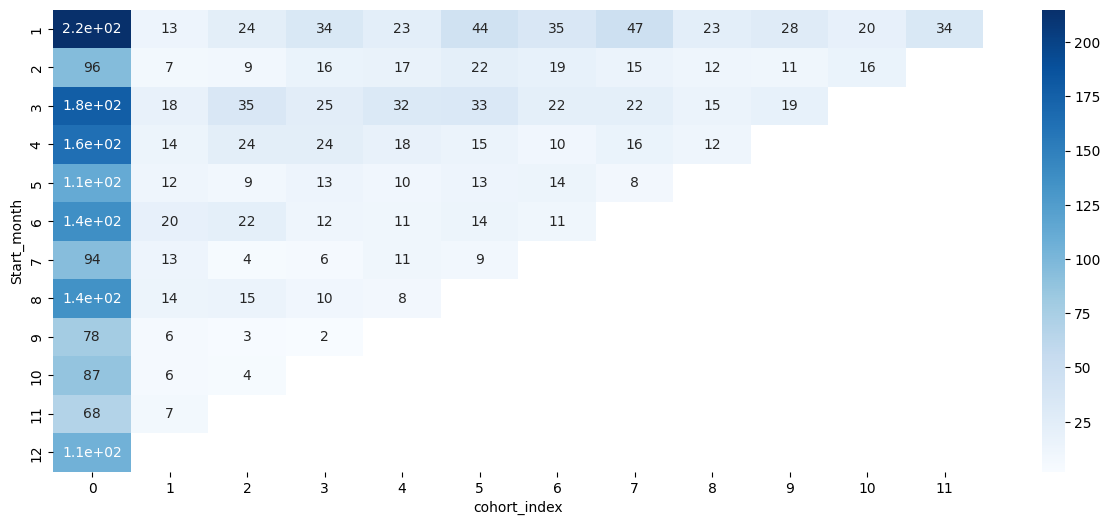

In [32]:
# Performing cohort analysis to calculate how many customers are retained for each month.
cohort_data=sales.groupby(['Start_month', 'cohort_index'])['CustomerID'].agg(pd.Series.nunique).reset_index()
cc = cohort_data.pivot_table(index = 'Start_month',columns = 'cohort_index',values = 'CustomerID')
plt.figure(figsize=(15,6))
sns.heatmap(cc, cmap='Blues', annot=True)
plt.show()

• How the revenues from existing/new customers on month on month basis

In [33]:
# The data here is now being taken by transactions done(The data here is grouped by transactions, as the data being grouped at product level does not show the total amount transacted)
c=sales.groupby(by='Transaction_ID').agg({'Invoice_amount':'sum'}).reset_index()
c.rename(columns={'Invoice_amount':'Total_Amount'}, inplace=True)
sales=sales.merge(c, on='Transaction_ID', how='left')

<Figure size 640x480 with 0 Axes>

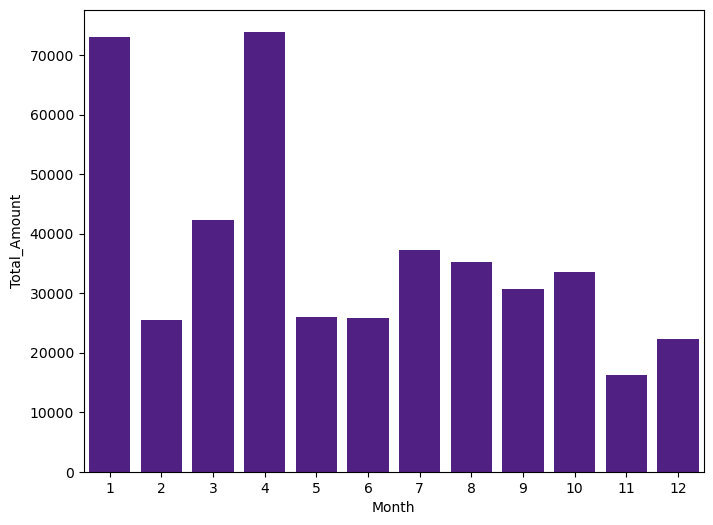

Text(0.5, 1.0, 'Revenue by New Customers Monthly')

In [21]:
# Finding and plotting the monthly revenue by new customers
new_cust_sales=sales.drop_duplicates(subset='CustomerID', keep='first').groupby(by='Month')['Total_Amount'].sum().reset_index()
plt.clf()
plt.figure(figsize=(8,6))
sns.barplot(x=new_cust_sales['Month'], y=new_cust_sales['Total_Amount'], color='#501192e8')
plt.show()
plt.title('Revenue by New Customers Monthly')

In [29]:
new_cust_sales

Month  Total_Amount
0       1   73044.79564
1       2   25492.41472
2       3   42246.41248
3       4   73924.77754
4       5   25980.68864
5       6   25761.04264
6       7   37210.17074
7       8   35174.44616
8       9   30772.86020
9      10   33504.25580
10     11   16172.23944
11     12   22376.05379

<Figure size 640x480 with 0 Axes>

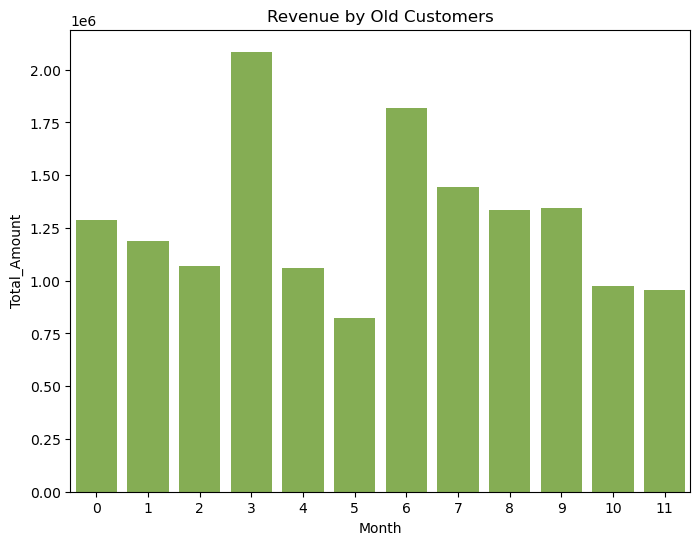

In [22]:
# Finding the sales by old customers by first finding total sales and subtracting new customer sales
total_sales=sales.groupby(by='Month')['Total_Amount'].sum().reset_index()
old_cust_sales= total_sales-new_cust_sales
old_cust_sales= old_cust_sales.reset_index().drop(columns='Month')
plt.clf()
plt.figure(figsize=(8,6))
sns.barplot(x=old_cust_sales['index'], y=old_cust_sales['Total_Amount'], color='#87bc45')
plt.title('Revenue by Old Customers')
plt.xlabel('Month')
plt.show()

• How the discounts playing role in the revenues?

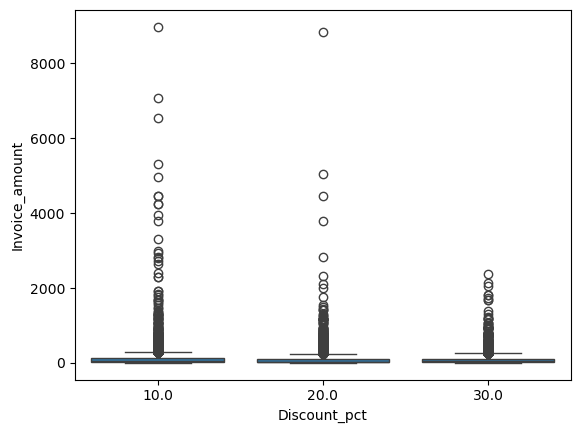

In [23]:
sns.boxplot(x=sales['Discount_pct'], y=sales['Invoice_amount'])
plt.show()

 Analyse KPI’s like Revenue, number of orders, average order value, number of plt.figure(figsize=(15,6))
plt.clf()
sns.barplot(data=sales.groupby('week')['Invoice_amount'].sum().to_frame().reset_index(),palette='husl', x='week', y='Invoice_amount')
 customers (existing/new), quantity, by category, by month, by week, by day etc…

<Figure size 640x480 with 0 Axes>

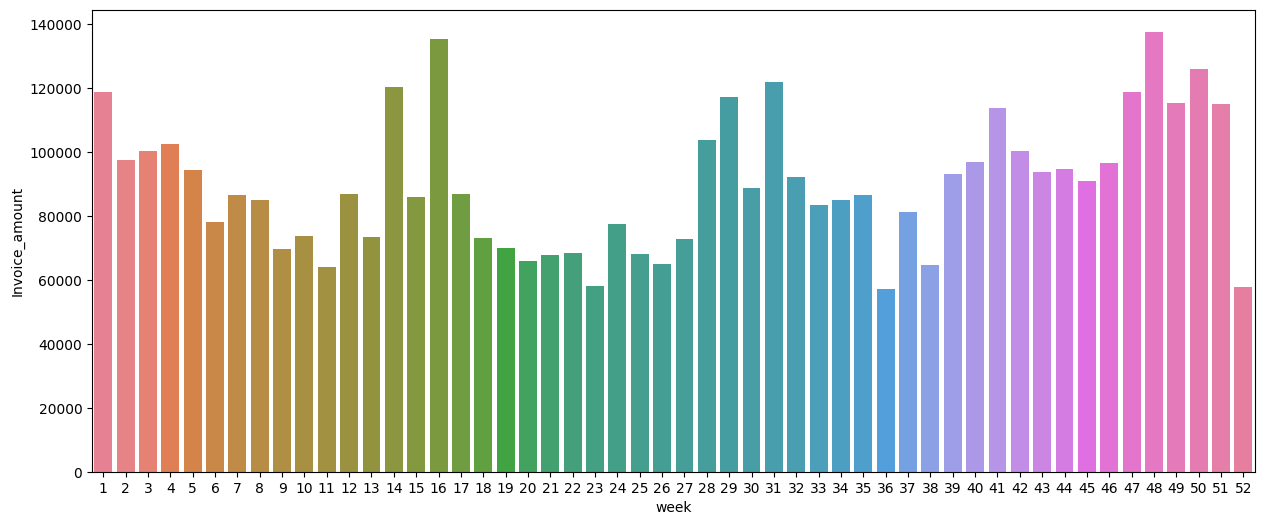

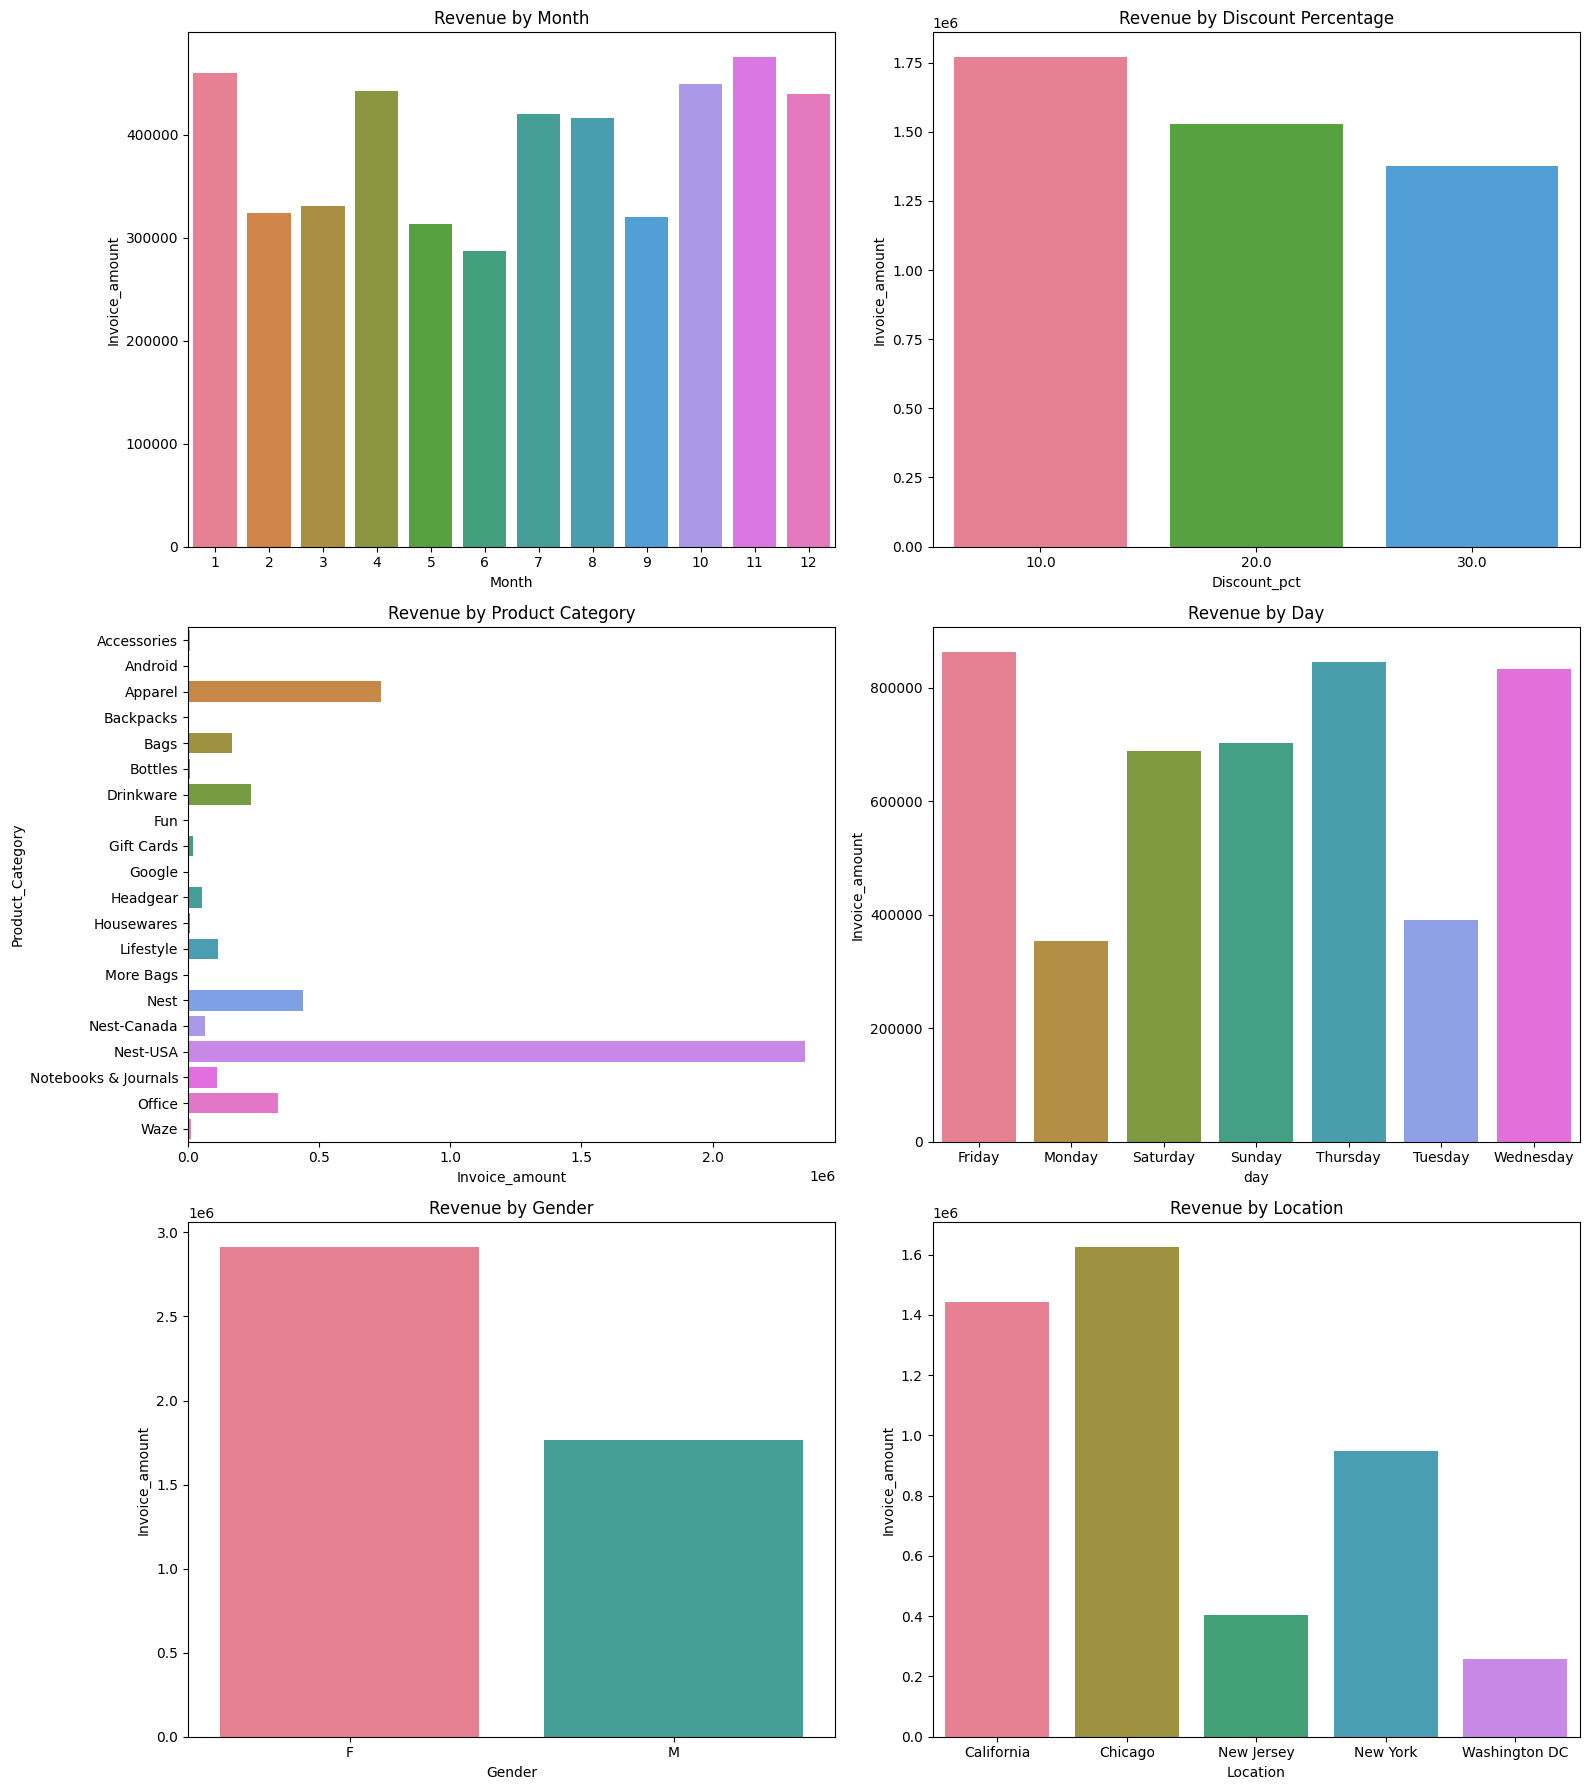

In [49]:
# Revenue by week, month, Discount, Product Category and Day
plt.clf()
plt.figure(figsize=(15,6))
sns.barplot(data=sales.groupby('week')['Invoice_amount'].sum().reset_index(),palette='husl', x='week', y='Invoice_amount')

# Creating a 2x3 subplot grid
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(16, 18))

# Revenue by Month
sns.barplot(data=sales.groupby('Month')['Invoice_amount'].sum().reset_index(),palette='husl', x='Month', y='Invoice_amount', ax=axes[0, 0])
axes[0, 0].set_title('Revenue by Month')

# Revenue by Discount Percentage
sns.barplot(data=sales.groupby('Discount_pct')['Invoice_amount'].sum().reset_index(),palette='husl', x='Discount_pct', y='Invoice_amount', ax=axes[0, 1])
axes[0, 1].set_title('Revenue by Discount Percentage')

# Revenue by Product Category
sns.barplot(data=sales.groupby('Product_Category')['Invoice_amount'].sum().reset_index(),palette='husl', y='Product_Category', x='Invoice_amount', ax=axes[1, 0])
axes[1, 0].set_title('Revenue by Product Category')

# Revenue by Day
sns.barplot(data=sales.groupby('day')['Invoice_amount'].sum().reset_index(),palette='husl', x='day', y='Invoice_amount', ax=axes[1, 1])
axes[1, 1].set_title('Revenue by Day')

# Revenue by Gender
sns.barplot(data=sales.groupby('Gender')['Invoice_amount'].sum().reset_index(),palette='husl', x='Gender', y='Invoice_amount', ax=axes[2, 0])
axes[2, 0].set_title('Revenue by Gender')

# Revenue by Location
sns.barplot(data=sales.groupby('Location')['Invoice_amount'].sum().reset_index(),palette='husl', x='Location', y='Invoice_amount', ax=axes[2, 1])
axes[2, 1].set_title('Revenue by Location')

# Adjust layout
plt.tight_layout()
plt.show()


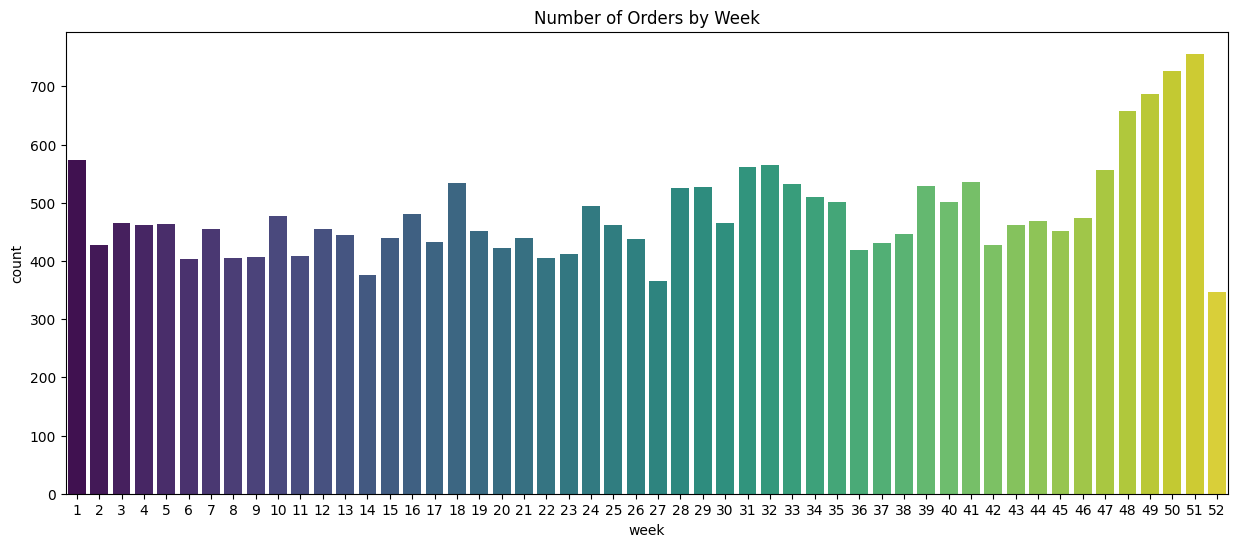

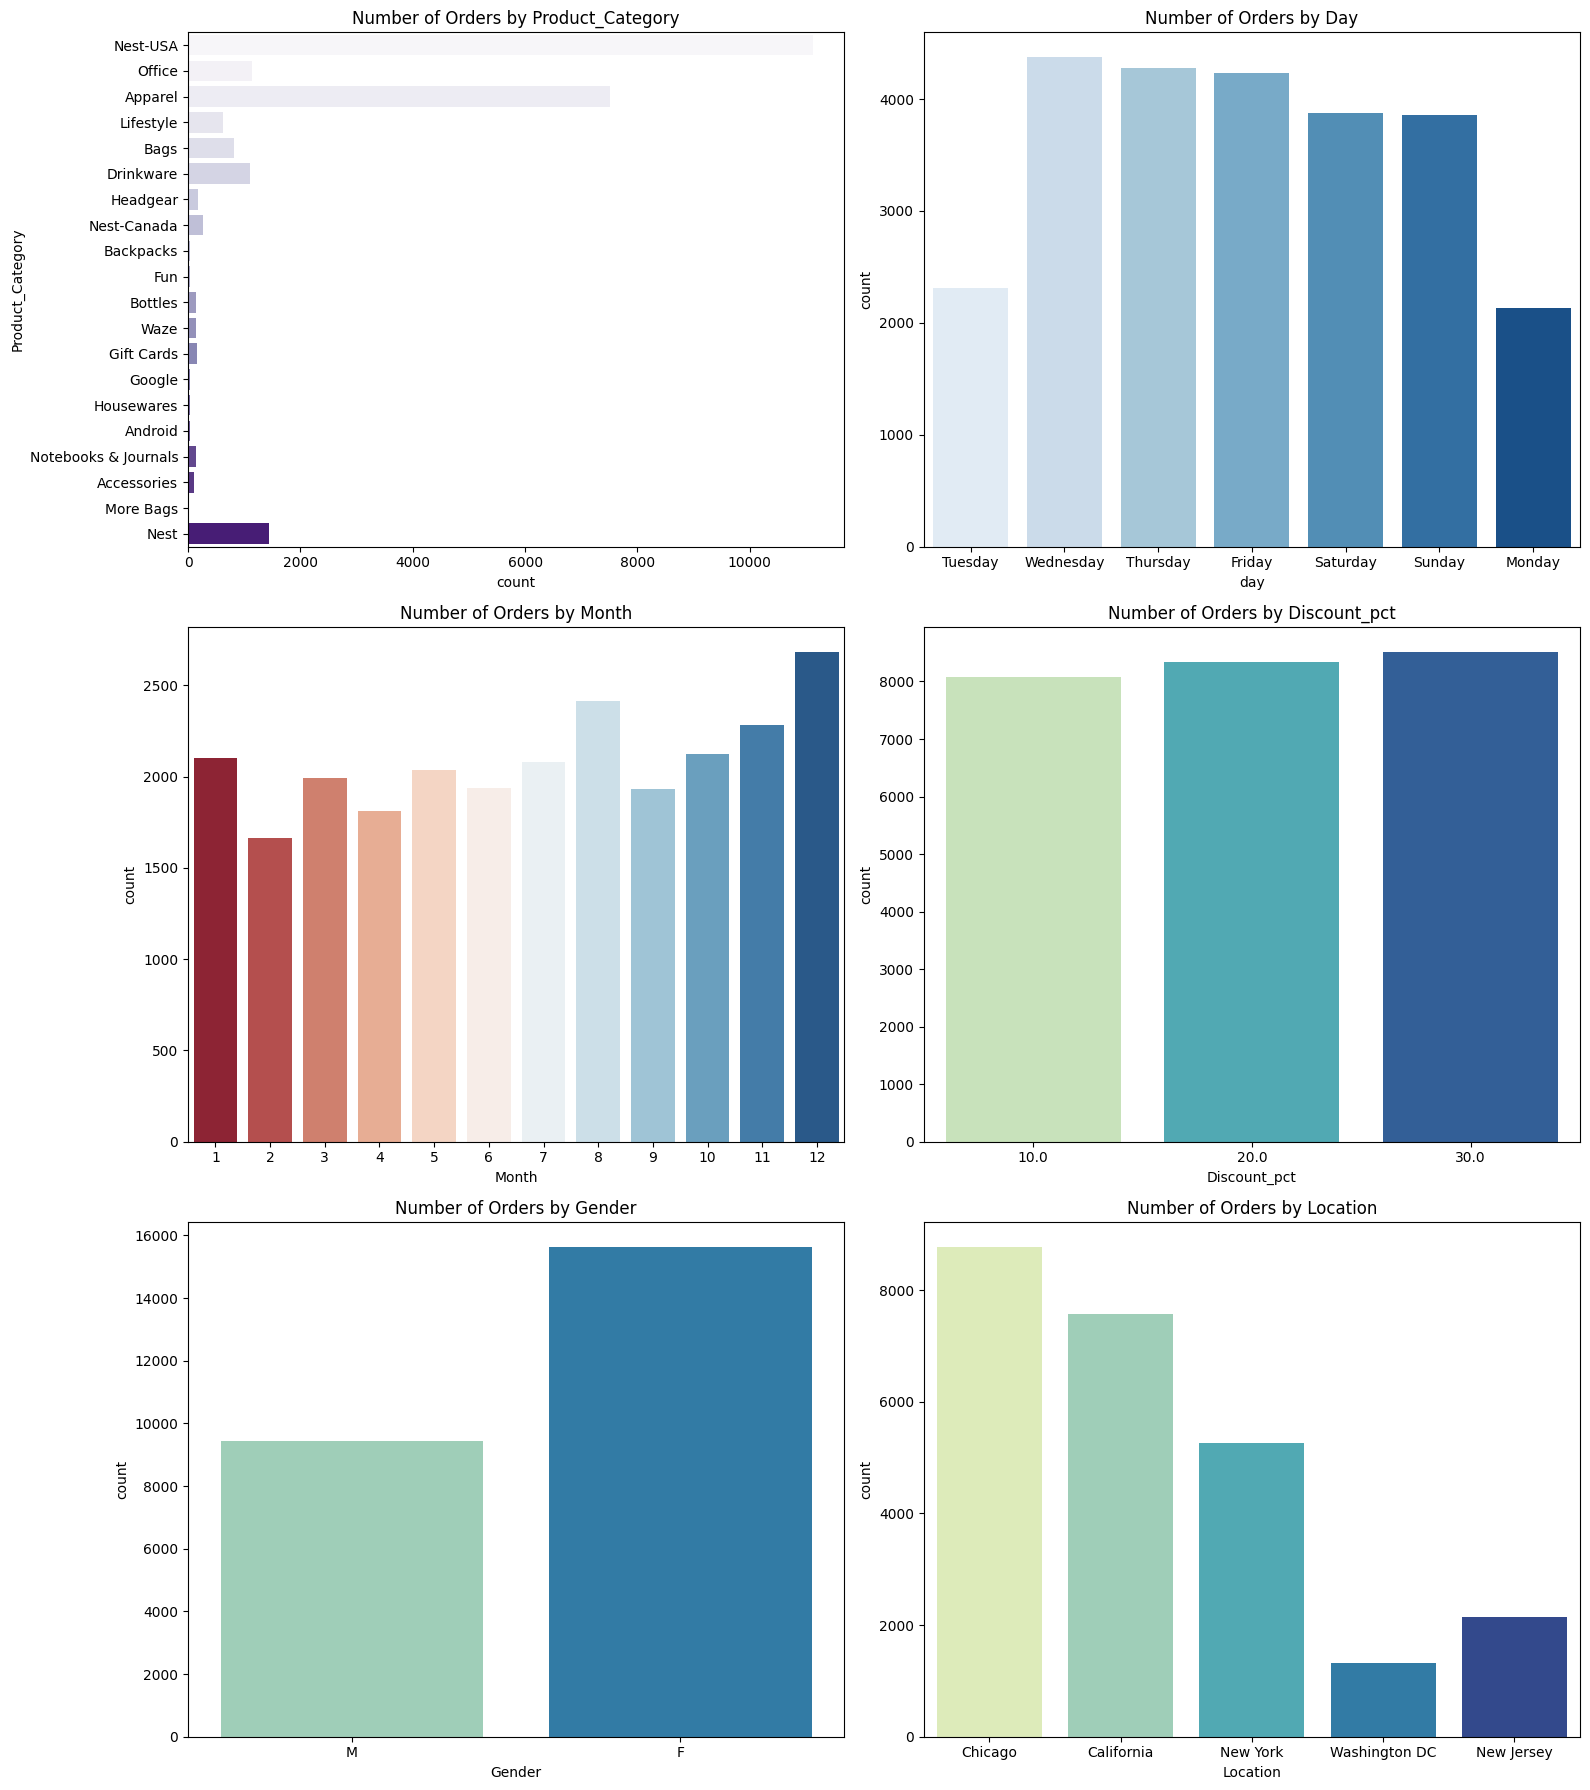

In [50]:
#Number of Orders

plt.figure(figsize=(15, 6))
sns.countplot(x=sales.drop_duplicates(subset=['Transaction_ID']).week, palette='viridis').set_title('Number of Orders by Week')

# Creating subplots
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(16, 18))

sns.countplot(x=sales.drop_duplicates(subset=['Transaction_ID']).day, ax=axes[0, 1], palette='Blues').set_title('Number of Orders by Day')
sns.countplot(y=sales.drop_duplicates(subset=['Transaction_ID']).Product_Category, ax=axes[0, 0], palette='Purples').set_title('Number of Orders by Product_Category')
sns.countplot(x=sales.drop_duplicates(subset=['Transaction_ID']).Month, ax=axes[1, 0], palette='RdBu').set_title('Number of Orders by Month')
sns.countplot(x=sales.drop_duplicates(subset=['Transaction_ID']).Discount_pct, ax=axes[1, 1], palette='YlGnBu').set_title('Number of Orders by Discount Percentage')
sns.countplot(x=sales.drop_duplicates(subset=['Transaction_ID']).Gender, ax=axes[2,0], palette='YlGnBu').set_title('Number of Orders by Gender')
sns.countplot(x=sales.drop_duplicates(subset=['Transaction_ID']).Location, ax=axes[2, 1], palette='YlGnBu').set_title('Number of Orders by Location')

plt.tight_layout()  # Adjusting the plots 
plt.show()


<Figure size 640x480 with 0 Axes>

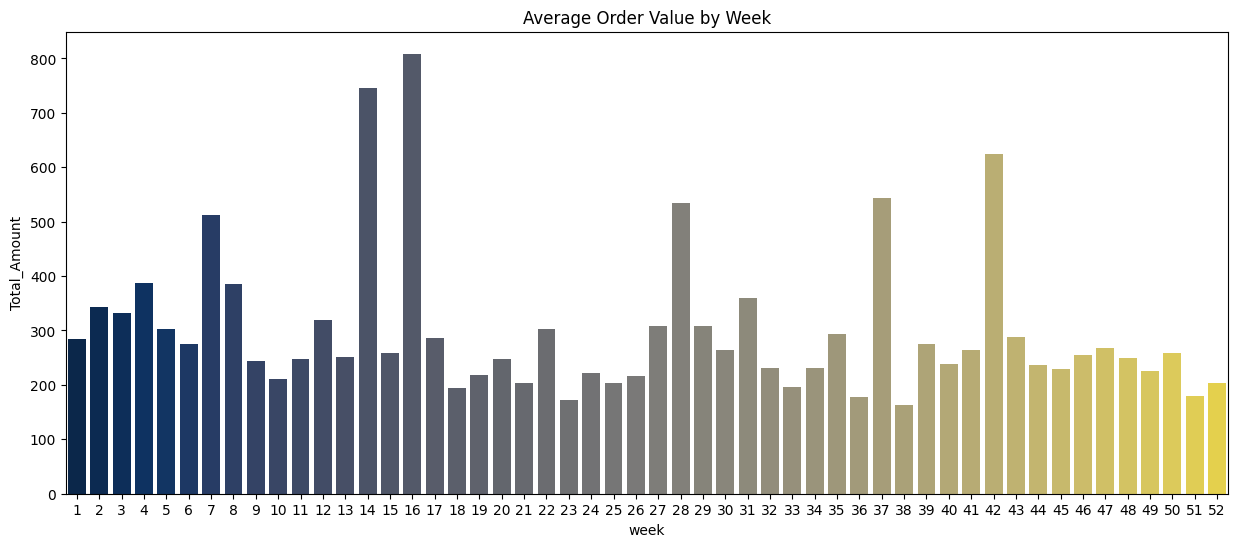

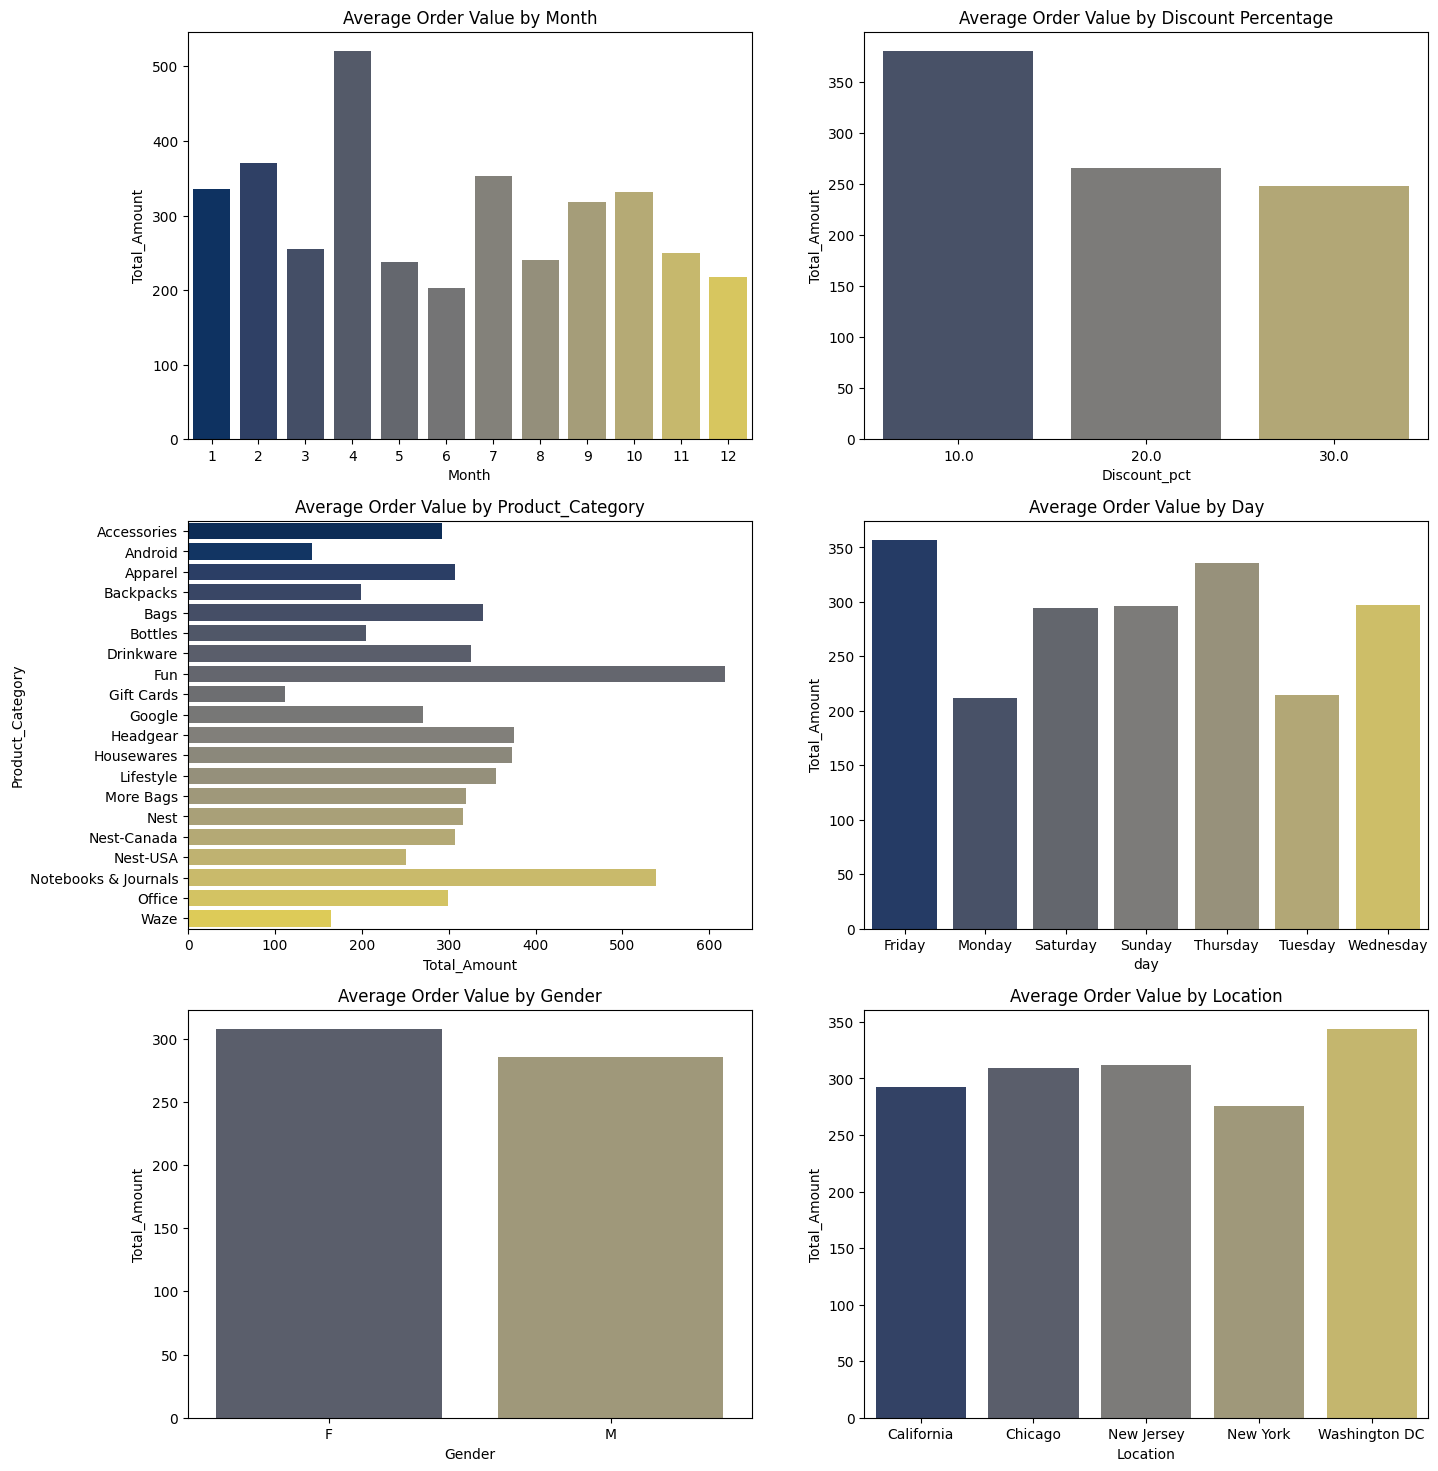

In [53]:
#Average order value
plt.clf()
plt.figure(figsize=(15,6))
sns.barplot(data=sales.groupby('week')['Total_Amount'].mean().reset_index(),palette='cividis',x='week', y='Total_Amount').set_title('Average Order Value by Week')

fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(16, 18))

sns.barplot(data=sales.groupby('Month')['Total_Amount'].mean().reset_index(), x='Month', y='Total_Amount',palette='cividis', ax=axes[0,0]).set_title('Average Order Value by Month')
sns.barplot(data=sales.groupby('Discount_pct')['Total_Amount'].mean().reset_index(), x='Discount_pct', y='Total_Amount',palette='cividis', ax=axes[0][1]).set_title('Average Order Value by Discount Percentage')
sns.barplot(data=sales.groupby('Product_Category')['Total_Amount'].mean().reset_index(), y='Product_Category', x='Total_Amount',palette='cividis',ax=axes[1,0]).set_title('Average Order Value by Product_Category')
sns.barplot(data=sales.groupby('day')['Total_Amount'].mean().reset_index(), x='day', y='Total_Amount',palette='cividis', ax=axes[1,1]).set_title('Average Order Value by Day')
sns.barplot(data=sales.groupby('Gender')['Total_Amount'].mean().reset_index(), x='Gender', y='Total_Amount',palette='cividis', ax=axes[2,0]).set_title('Average Order Value by Gender')
sns.barplot(data=sales.groupby('Location')['Total_Amount'].mean().reset_index(), x='Location', y='Total_Amount',palette='cividis', ax=axes[2,1]).set_title('Average Order Value by Location')
plt.show()

<Figure size 640x480 with 0 Axes>

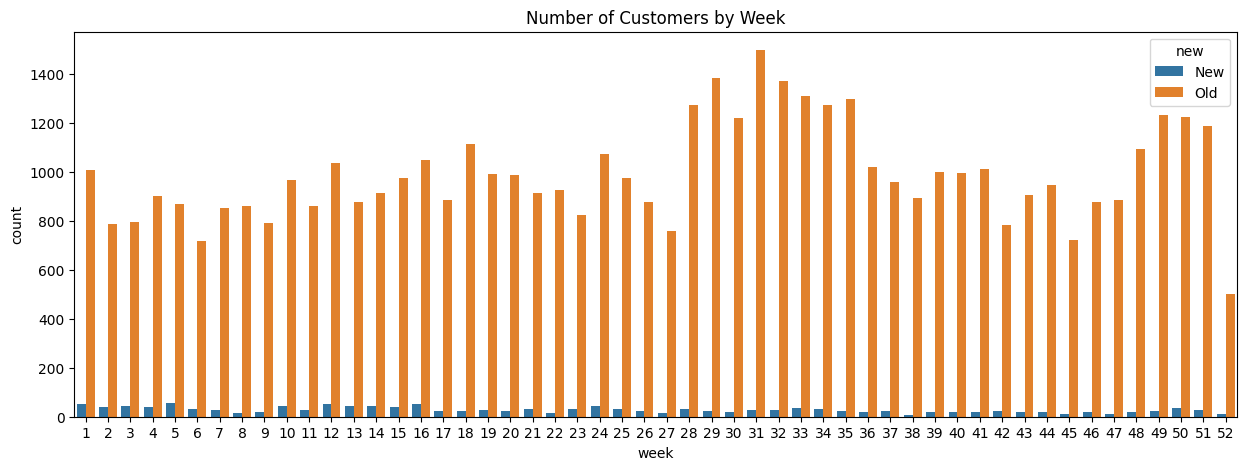

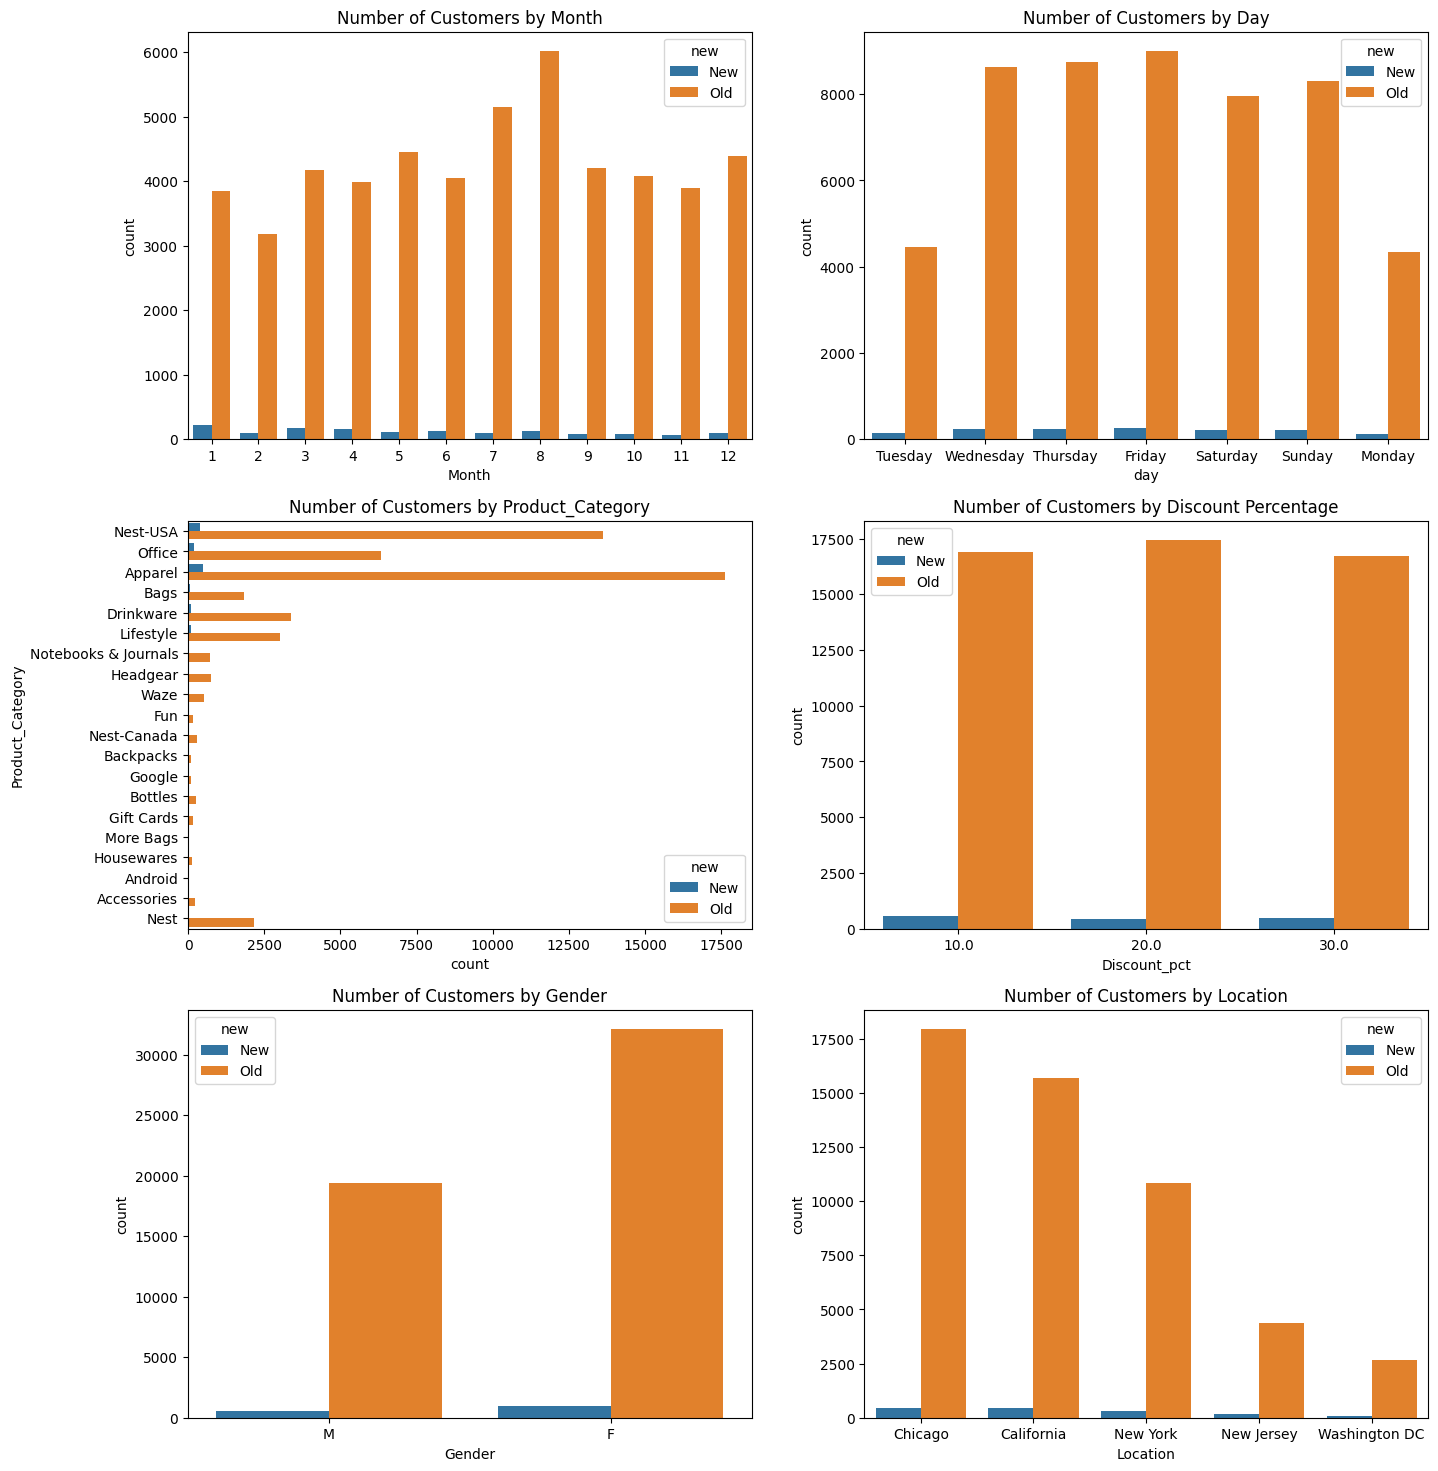

In [85]:
# No. of customers(new and old)

new_cust=sales.drop_duplicates(subset='CustomerID', keep='first').index
sales['Customers(Old & New)']= np.where(sales.index.isin(new_cust), 'New', 'Old')

plt.clf()
plt.figure(figsize=(15,5))
sns.countplot(x=sales.week, hue=sales.new).set_title('Number of Customers by Week')

fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(16, 18))

sns.countplot(x=sales.Month, hue=sales.new,ax=axes[0,0]).set_title('Number of Customers by Month')
sns.countplot(x=sales.day, hue=sales.new,ax=axes[0,1]).set_title('Number of Customers by Day')
sns.countplot(y=sales.Product_Category, hue=sales.new ,ax=axes[1,0]).set_title('Number of Customers by Product_Category')
sns.countplot(x=sales.Discount_pct, hue=sales.new ,ax=axes[1,1]).set_title('Number of Customers by Discount Percentage')
sns.countplot(x=sales.Gender, hue=sales.new ,ax=axes[2,0]).set_title('Number of Customers by Gender')
sns.countplot(x=sales.Location, hue=sales.new ,ax=axes[2,1]).set_title('Number of Customers by Location')

plt.show()

<Figure size 640x480 with 0 Axes>

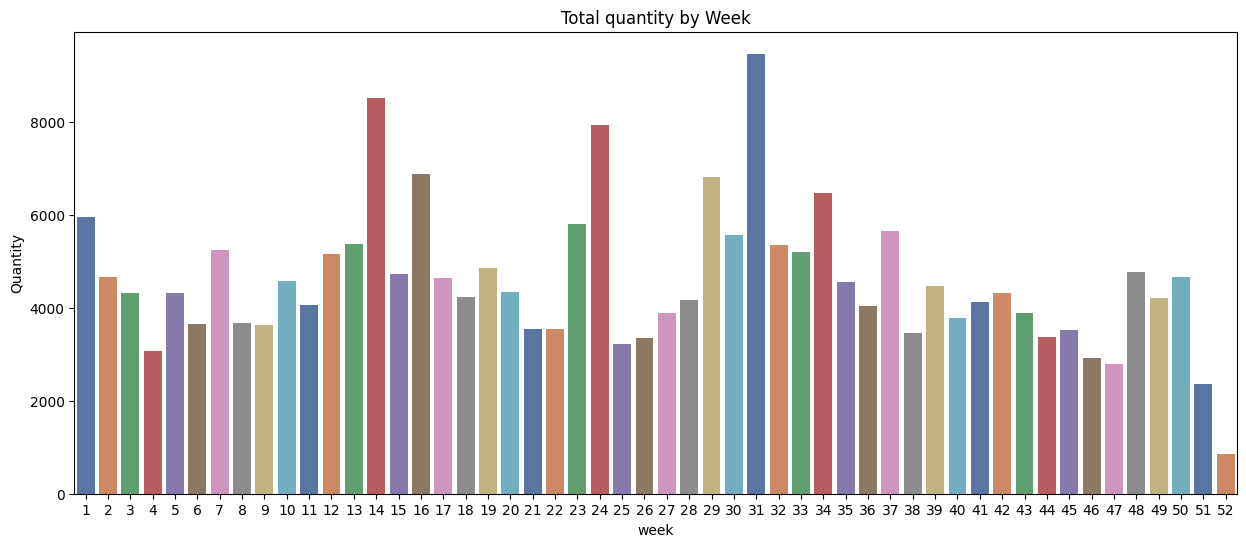

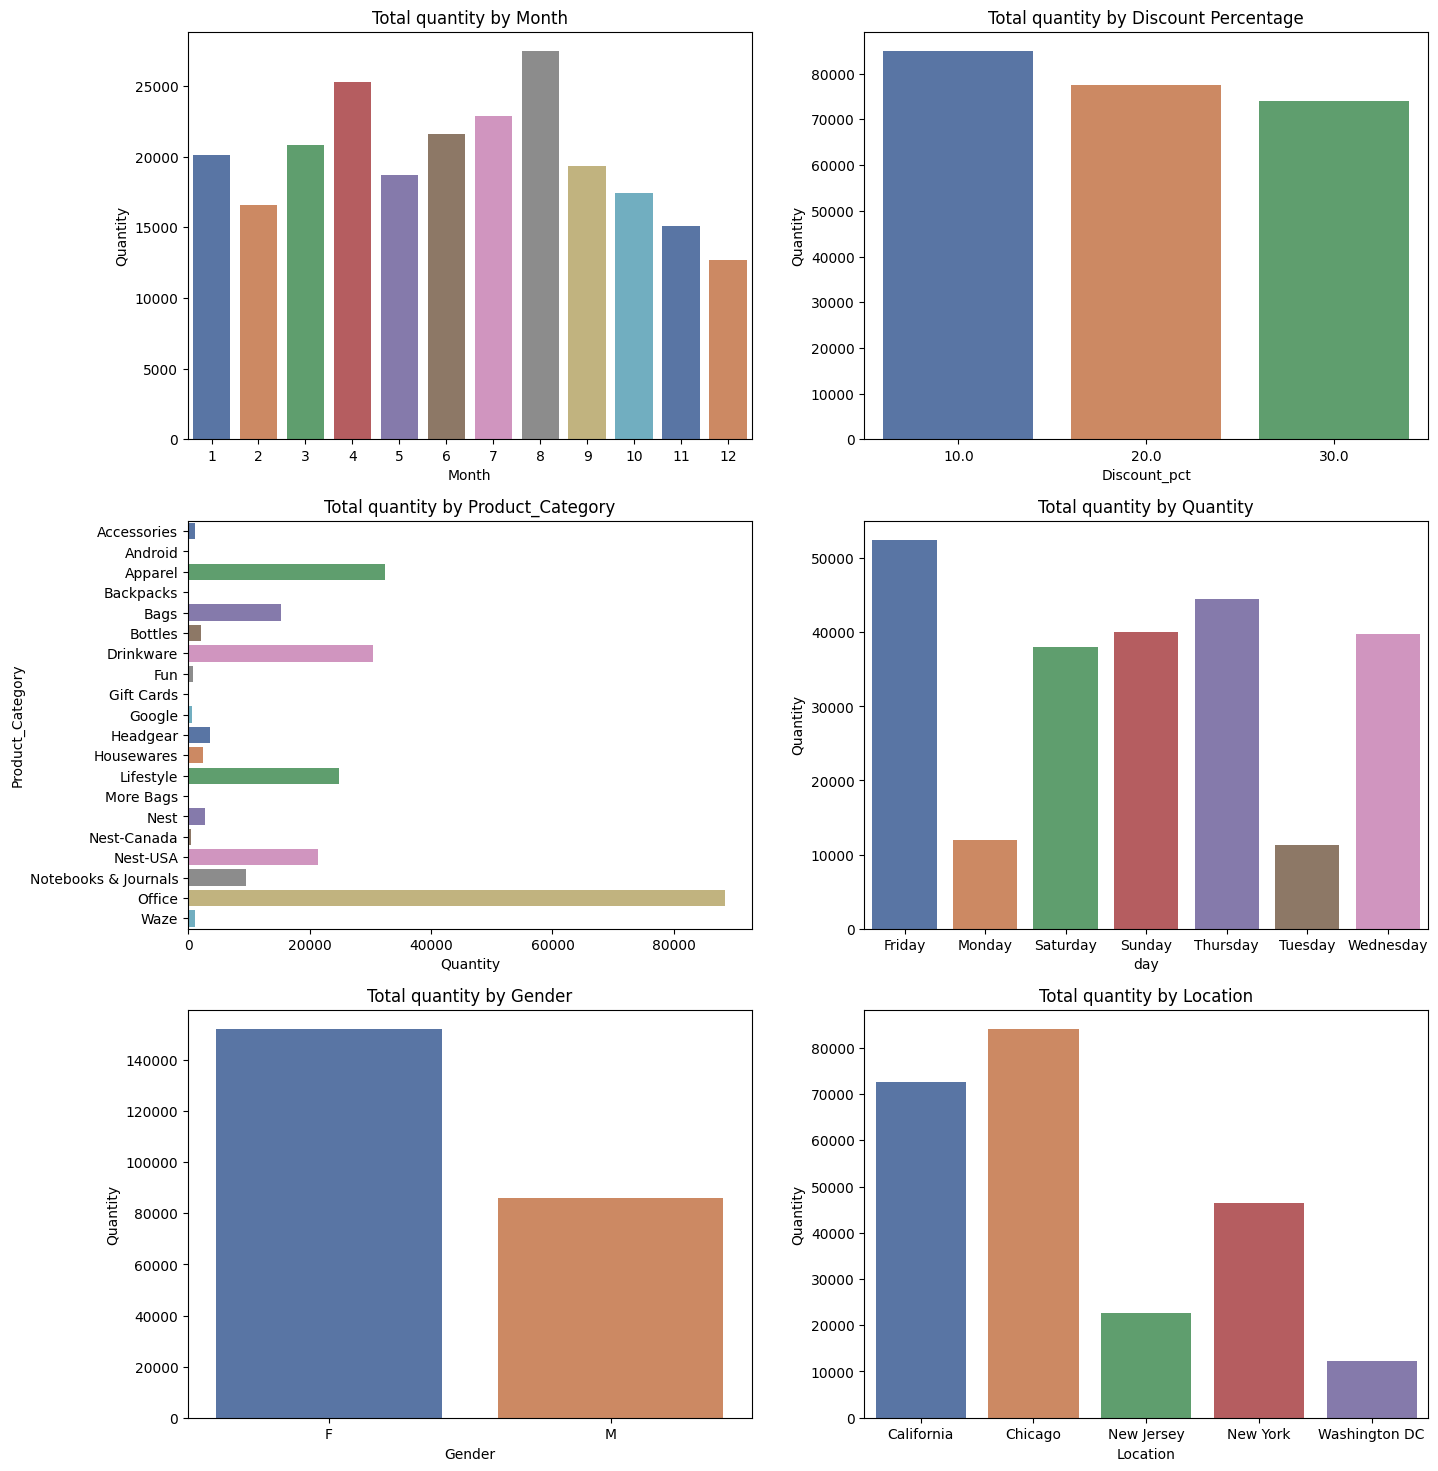

In [58]:
# Quantity
plt.clf()
plt.figure(figsize=(15,6))
sns.barplot(data=sales.groupby('week')['Quantity'].sum().reset_index(),palette='deep', x='week', y='Quantity').set_title('Total quantity by Week')

fig, axes= plt.subplots(ncols=2,nrows=3, figsize=(16,18))
sns.barplot(data=sales.groupby('Month')['Quantity'].sum().reset_index(),palette='deep', x='Month', y='Quantity', ax=axes[0,0]).set_title('Total quantity by Month')
sns.barplot(data=sales.groupby('Discount_pct')['Quantity'].sum().reset_index(),palette='deep', x='Discount_pct', y='Quantity', ax=axes[0,1]).set_title('Total quantity by Discount Percentage')
sns.barplot(data=sales.groupby('Product_Category')['Quantity'].sum().reset_index(),palette='deep', y='Product_Category', x='Quantity', ax=axes[1,0]).set_title('Total quantity by Product_Category')
sns.barplot(data=sales.groupby('day')['Quantity'].sum().reset_index(),palette='deep', x='day', y='Quantity', ax=axes[1,1]).set_title('Total quantity by Quantity')
sns.barplot(data=sales.groupby('Gender')['Quantity'].sum().reset_index(),palette='deep', x='Gender', y='Quantity', ax=axes[2,0]).set_title('Total quantity by Gender')
sns.barplot(data=sales.groupby('Location')['Quantity'].sum().reset_index(),palette='deep', x='Location', y='Quantity',  ax=axes[2,1]).set_title('Total quantity by Location')
plt.show()

• Understand the trends/seasonality of sales by category, location, month etc…

<Figure size 640x480 with 0 Axes>

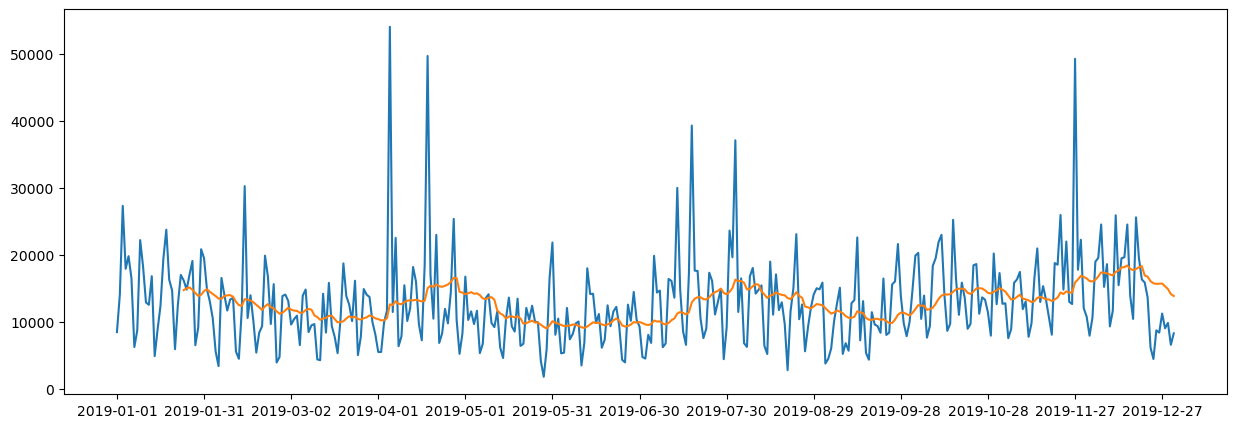

In [28]:
plt.clf()
plt.figure(figsize=(15,5))
a= sales[['Transaction_Date','Invoice_amount']].groupby(by='Transaction_Date').sum()
plt.plot(a)
plt.plot(a.rolling(24).mean()) 
plt.xticks(a.index[::30])
plt.show()

• Understand the trends/seasonality of sales by category, location, month etc…

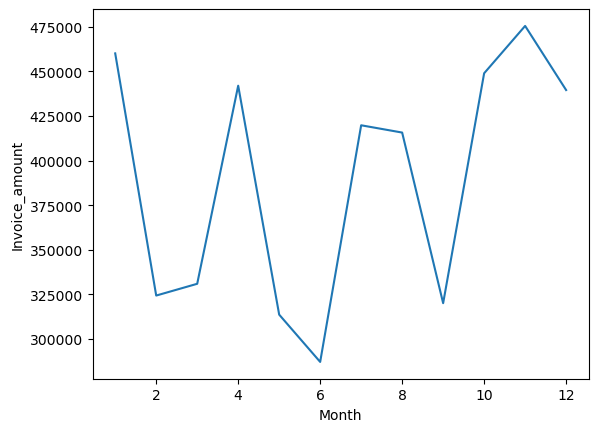

In [29]:
# By month
a= sales[['Month','Invoice_amount']].groupby(by='Month').sum()
sns.lineplot(data=a,  x='Month', y='Invoice_amount')
plt.show()

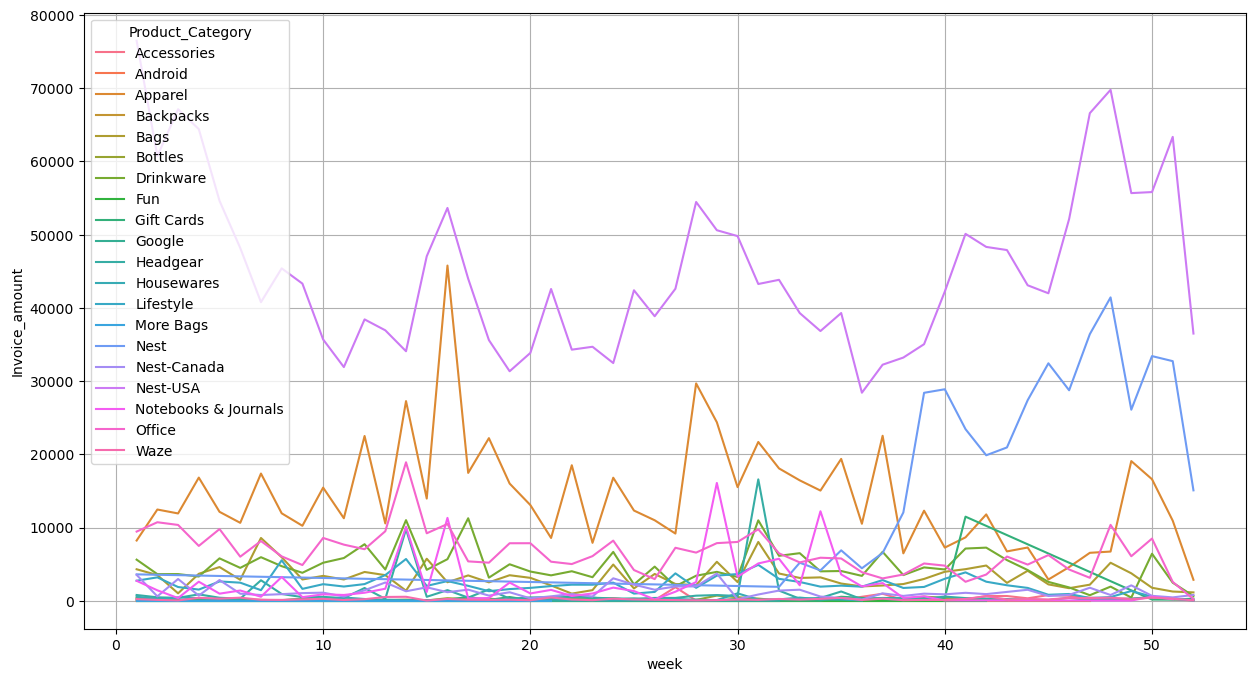

In [30]:
# Weekly trend by categories
plt.figure(figsize=(15,8))
a=sales.groupby(by=['Product_Category','week'])['Invoice_amount'].sum().reset_index()
#a['Invoice_amount']= a['Invoice_amount'].rolling(3).sum()
sns.lineplot(data=a, x='week', y='Invoice_amount', hue='Product_Category')
plt.grid()
plt.show()

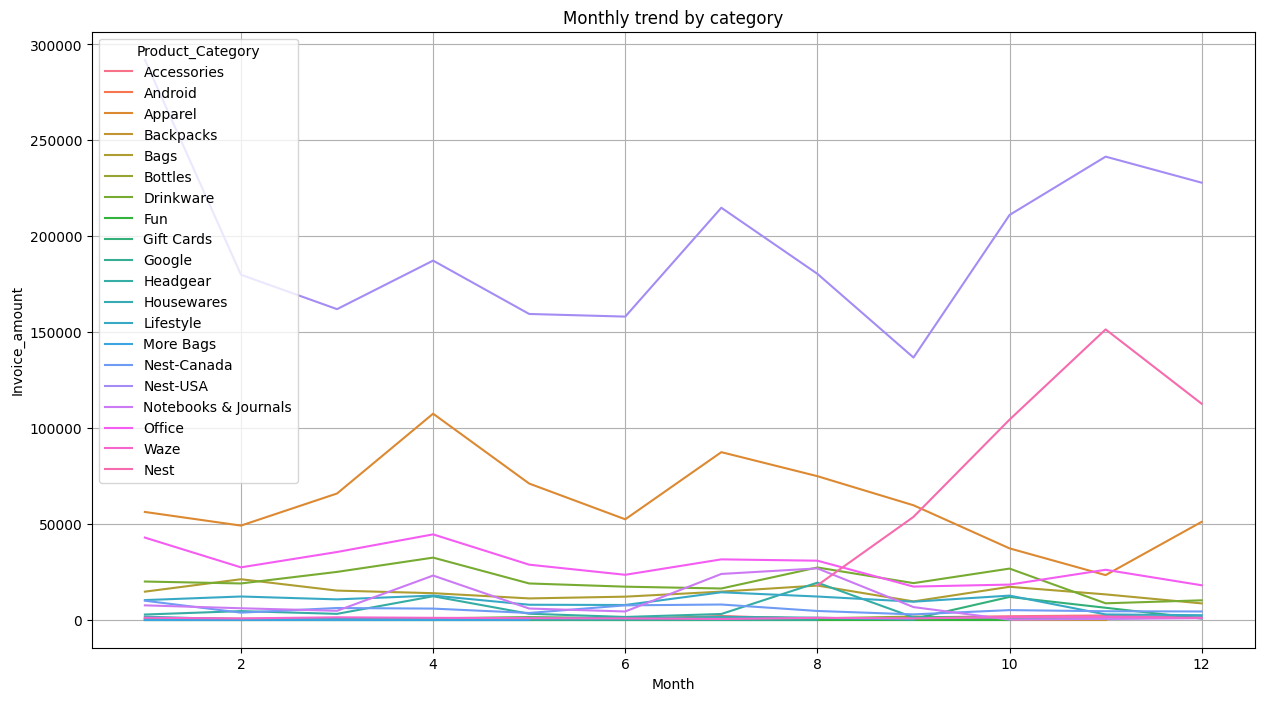

In [17]:
# Monthly trend by categories
plt.figure(figsize=(15,8))
a=sales.groupby(by=['Month','Product_Category'])['Invoice_amount'].sum().reset_index()
sns.lineplot(data=a, x='Month', y='Invoice_amount', hue='Product_Category')
plt.title('Monthly trend by category')
plt.grid()
plt.show()

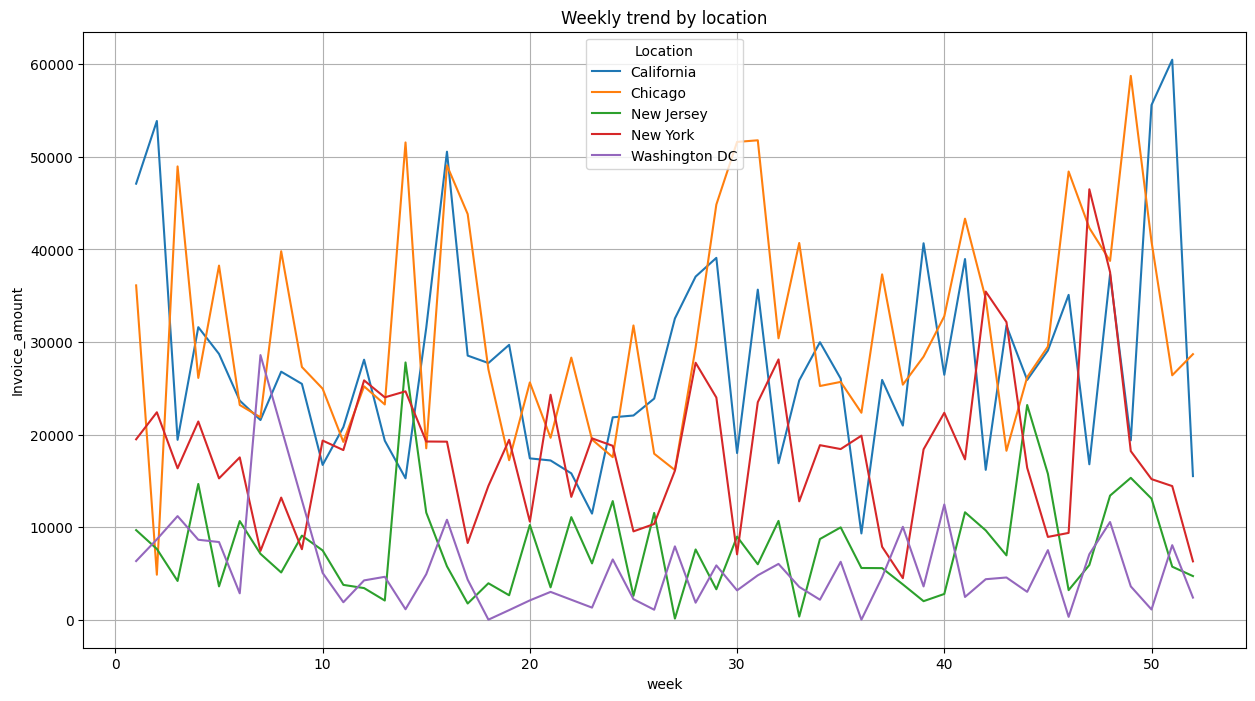

In [18]:
# Weekly trend by location
plt.figure(figsize=(15,8))
a=sales.groupby(by=['week','Location'])['Invoice_amount'].sum().reset_index()
#a['Invoice_amount']= a['Invoice_amount'].rolling(12).mean()
sns.lineplot(data=a, x='week', y='Invoice_amount', hue='Location')
plt.title('Weekly trend by location')
plt.grid()
plt.show()

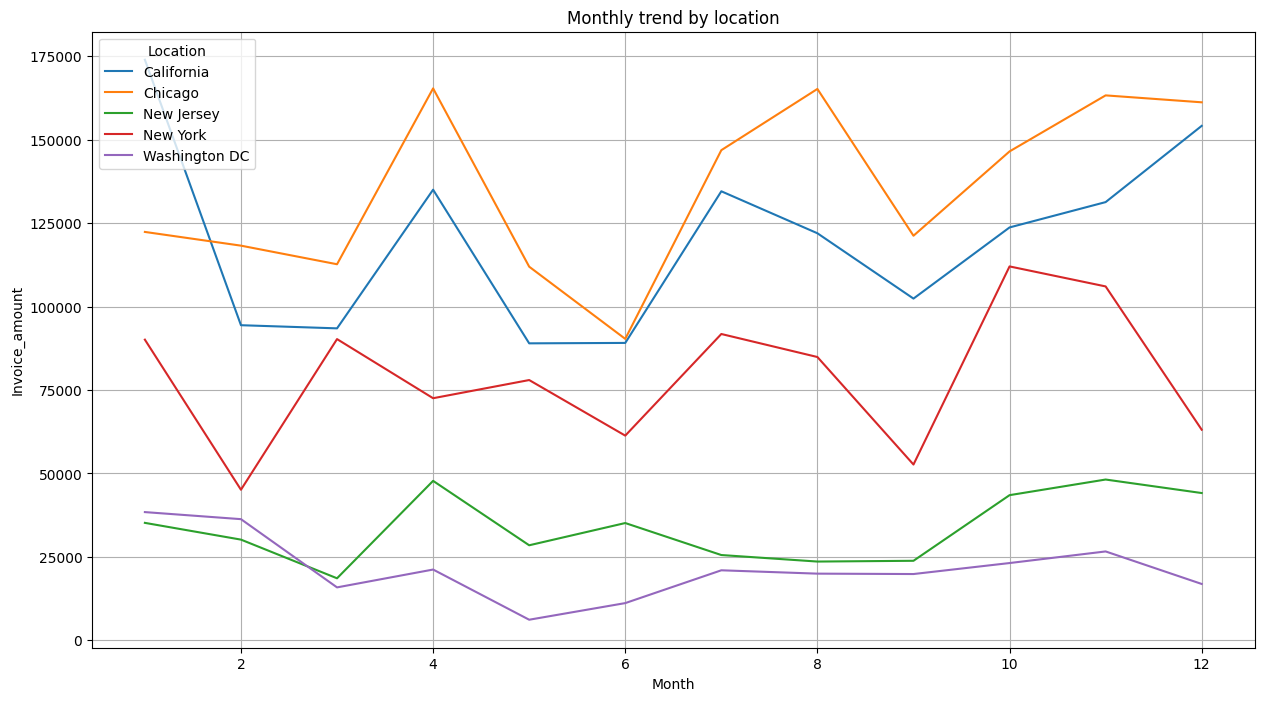

In [19]:
# Montly trend by location
plt.figure(figsize=(15,8))
a=sales.groupby(by=['Month','Location'])['Invoice_amount'].sum().reset_index()
sns.lineplot(data=a, x='Month', y='Invoice_amount', hue='Location')
plt.title('Monthly trend by location')
plt.grid()
plt.show()

• How number order varies and sales with different days?

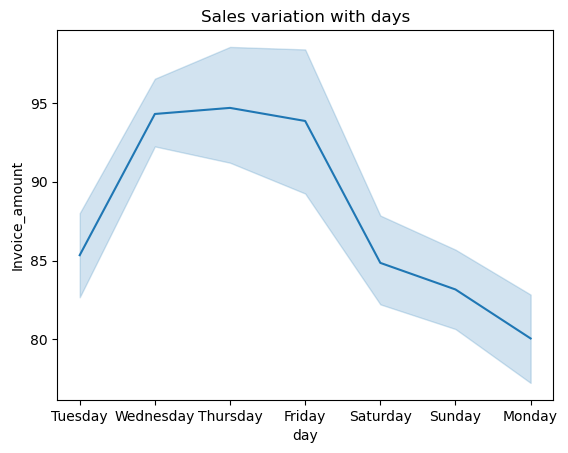

In [34]:
sns.lineplot(x = 'day', y = 'Invoice_amount', data = sales)
plt.title('Sales variation with days')
plt.show()

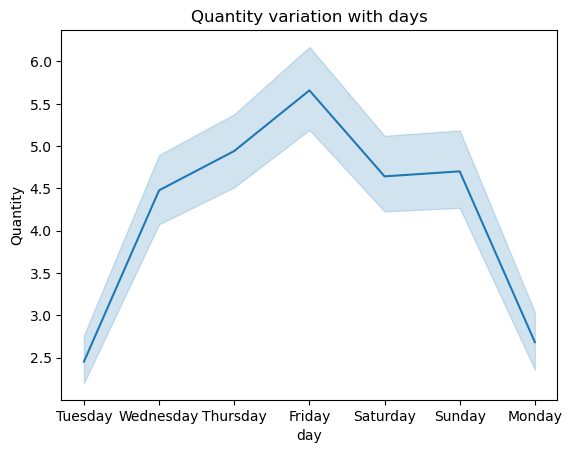

In [35]:
sns.lineplot(x = 'day', y = 'Quantity', data = sales)
plt.title('Quantity variation with days')
plt.show()

• Calculate the Revenue, Marketing spend, percentage of marketing spend out of
 revenue, Tax, percentage of delivery charges by month.

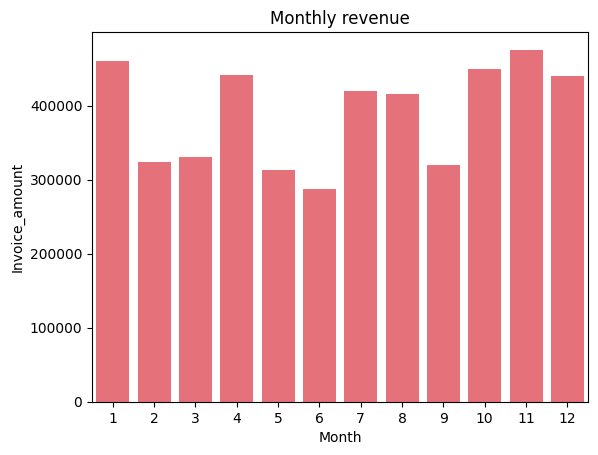

In [32]:
# Drop non-numeric columns from the sales DataFrame
sales_numeric = sales.select_dtypes(include=['number'])

monthly_revenue = sales_numeric.groupby(by='Month').sum().reset_index()
sns.barplot(data=monthly_revenue, x='Month', y='Invoice_amount', color='#f95d6a')
plt.title('Monthly revenue')
plt.show()


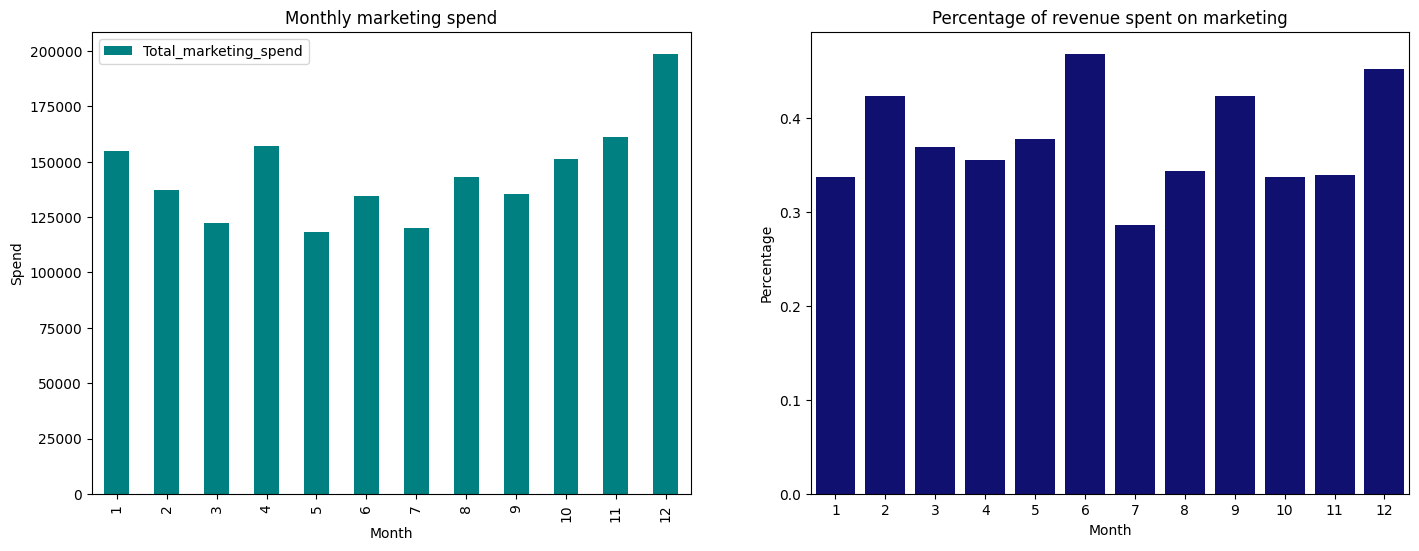

<Figure size 1700x600 with 0 Axes>

In [62]:
# Plotting monthly marketing spend and percetage of revenue spent of marketing
ma = marketing.groupby(marketing['Date'].dt.month)['Total_marketing_spend'].sum().reset_index()

fig, axes = plt.subplots(ncols=2, figsize=(17, 6))
plt.figure(figsize=(17,6))

# Plot 1: Monthly marketing spend
ma.plot(kind='bar', x='Date', y='Total_marketing_spend',ax=axes[0],color='#008080')
axes[0].set_title('Monthly marketing spend')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Spend')

# Ensure sales['Month'] exists and is grouped by correctly
b = (marketing.groupby(marketing['Date'].dt.month)['Total_marketing_spend'].sum() /
     sales.groupby('Month')['Invoice_amount'].sum()).to_frame()

# Plot 2: Percentage of revenue spent on marketing
plt.clf()
sns.barplot(data=b, x=b.index,y=0,ax=axes[1], color='#000080')
axes[1].set_title('Percentage of revenue spent on marketing')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Percentage')

plt.tight_layout()
plt.show()

In [63]:
# Calculating tax amount
sales['tax']= sales['Invoice_amount']*sales['GST']

In [65]:
sales['tax']

0        15.867290
1        15.867290
2         0.852950
3        17.925174
4         4.324140
           ...    
52919     9.990100
52920     8.443426
52921    12.344760
52922    31.650200
52923    26.799160
Name: tax, Length: 52924, dtype: float64

<Figure size 640x480 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

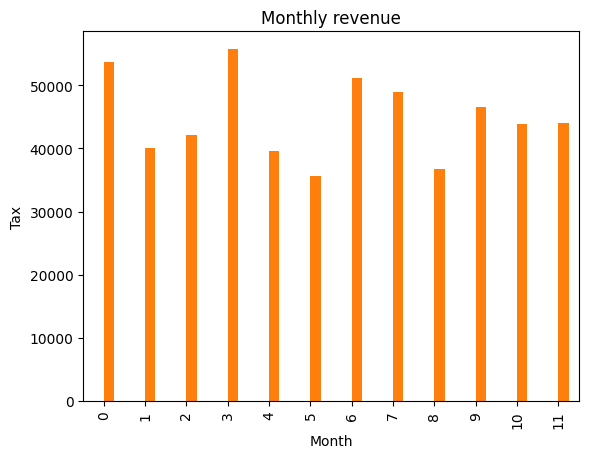

In [79]:
# Plotting montky Tax spend by months

mt=sales.groupby(by='Month')['tax'].sum().reset_index()

plt.clf()
plt.figure(figsize=(10, 6))
ma.plot(kind='bar')
plt.title('Monthly revenue')
plt.xlabel("Month")
plt.ylabel("Tax")
plt.legend().set_visible(False)

plt.show()



<Figure size 640x480 with 0 Axes>

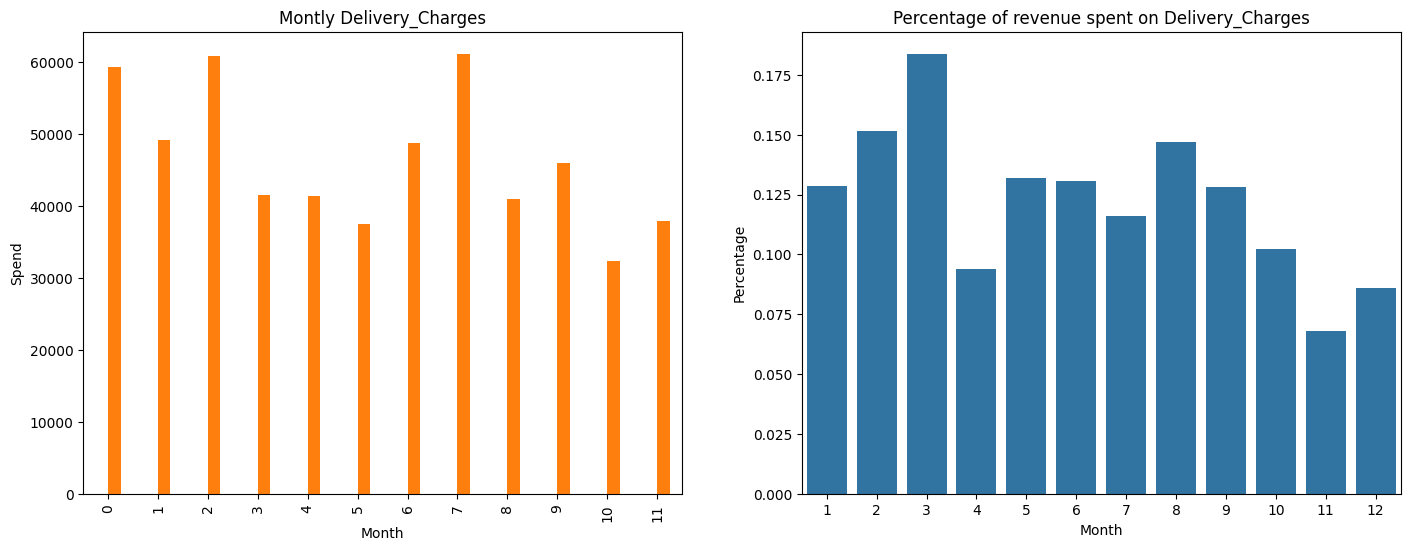

In [82]:
# # Plotting monthly spend on discount and percetage of revenue spent of discounts
dc=sales.groupby(by='Month')['Delivery_Charges'].sum().reset_index()

plt.clf()
fig, axes= plt.subplots(ncols=2, figsize=(17,6))
dc.plot(kind='bar', ax= axes[0], legend=False)
axes[0].set_title('Montly Delivery_Charges')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Spend')

b=(sales.groupby(by='Month')['Delivery_Charges'].sum()/sales.groupby(by='Month')['Invoice_amount'].sum()).to_frame()
sns.barplot(data=b, x=b.index, y=0, ax= axes[1])
axes[1].set_title('Percentage of Monthly Delivery_Charges ')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Percentage')
plt.show()



In [86]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52924 entries, 0 to 52923
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   CustomerID             52924 non-null  int64         
 1   Transaction_ID         52924 non-null  int64         
 2   Transaction_Date       52924 non-null  datetime64[ns]
 3   Product_SKU            52924 non-null  object        
 4   Product_Description    52924 non-null  object        
 5   Product_Category       52924 non-null  object        
 6   Quantity               52924 non-null  int64         
 7   Avg_Price              52924 non-null  float64       
 8   Delivery_Charges       52924 non-null  float64       
 9   Coupon_Status          52924 non-null  object        
 10  Month                  52924 non-null  int32         
 11  week                   52924 non-null  UInt32        
 12  day                    52924 non-null  object        
 13  Y

•  How marketing spend is impacting on revenue?

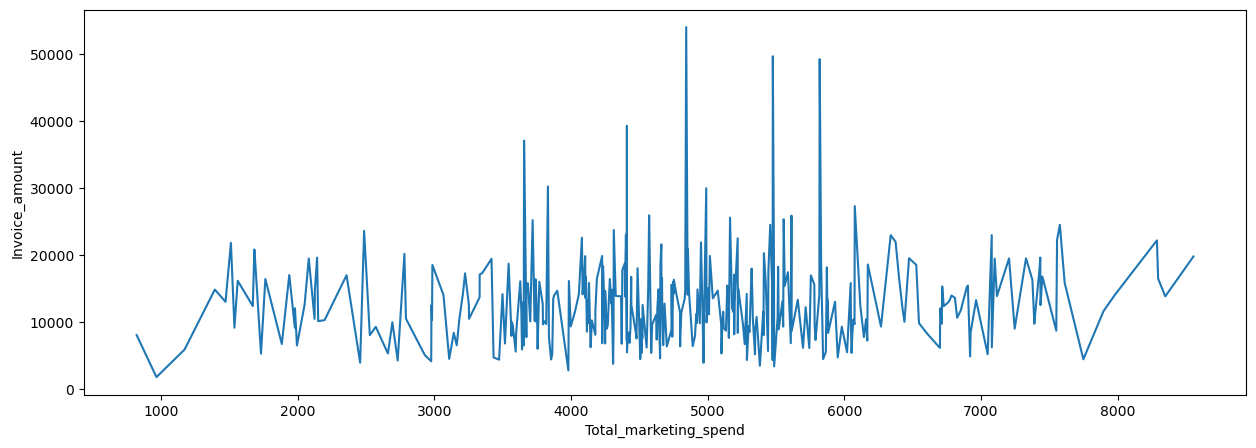

Correlation between marketing spend and revenue: 0.03833682168052941
Revenue goes up when marketing spend is between 3500 and 6000 and becomes stable


In [41]:
marketing_revenue=sales.groupby(by='Date').agg({'Total_marketing_spend':'mean', 'Invoice_amount':'sum'})
plt.figure(figsize=(15,5))
sns.lineplot(data=marketing_revenue, y='Invoice_amount',x='Total_marketing_spend')
plt.show()
print('Correlation between marketing spend and revenue:', sales[['Total_marketing_spend','Invoice_amount']].corr().loc['Total_marketing_spend','Invoice_amount'])
print('Revenue goes up when marketing spend is between 3500 and 6000 and becomes stable')

 • Which product was purchased mostly based on the quantity

In [44]:
# Top product by each month
top_prod_per_month=sales.groupby(by=['Month','Product_SKU'])['Transaction_ID'].count().to_frame().reset_index()
top_prod_per_month=top_prod_per_month.sort_values(by=['Month','Transaction_ID'], ascending=False)
top_prod_per_month.drop_duplicates(subset='Month', keep='first')

Month     Product_SKU  Transaction_ID
5907     12  GGOENEBJ079499             384
5694     11  GGOENEBJ079499             335
5490     10  GGOENEBQ078999             271
5154      9  GGOENEBB078899             212
4748      8  GGOENEBQ078999             276
4217      7  GGOENEBQ078999             289
3586      6  GGOENEBQ078999             294
2966      5  GGOENEBB078899             251
2333      4  GGOENEBB078899             244
1639      3  GGOENEBQ078999             316
978       2  GGOENEBJ079499             344
460       1  GGOENEBJ079499             586

# 3. Customer Segmentation

In [23]:
# Creating customer360 dataframe
sales['Transaction_Date'] = pd.to_datetime(sales['Transaction_Date'])
c1=sales.groupby(by='CustomerID').agg({'Transaction_ID':'nunique',
                                   'Quantity':'sum',
                                   'Delivery_Charges':'sum',
                                   'Invoice_amount':'sum',
                                   'Transaction_Date': (lambda x: (max(x)-min(x)))})
customer360= customer.merge(c1, on='CustomerID',how='inner')
customer360.rename(columns={'Transaction_ID':'Total_orders','Transaction_Date':'Tenure_days'}, inplace=True)
customer360.Tenure_days=customer360.Tenure_days.dt.days

 • Heuristic (Value based, RFM) – Divide the customers into Premium, Gold, Silver,
#Standard customers and define strategy on the same. 

In [23]:
# Creating a copy of customer data so we do not change the original table
sales_value_based= customer360.copy()

In [24]:
# Using qcut fucntion to divide the data in 10 segments based on invoice amount
sales_value_based['Segment']=pd.qcut(sales['Invoice_amount'],q=3, labels=False)
sales_value_based=sales_value_based.rename(columns={'Invoice_amount':'Total_revenue', 'Transaction_ID':'No. of transactions'})
sales_value_based

CustomerID Gender    Location  Tenure_Months  Total_orders  Quantity  \
0          17850      M     Chicago             12           177      1133   
1          13047      M  California             43            26       175   
2          12583      M     Chicago             33            15       155   
3          13748      F  California             30             1         1   
4          15100      M  California             49             6        15   
...          ...    ...         ...            ...           ...       ...   
1463       14438      F    New York             41             5        29   
1464       12956      F     Chicago             48            14        35   
1465       15781      M  New Jersey             19             3        10   
1466       14410      F    New York             45             6        11   
1467       14600      F  California              7             2         9   

      Delivery_Charges  Total_revenue  Tenure_days  Segment  
0              3162.62    37649.28181           25      2.0  
1               315.96     2876.28679          351      2.0  
2               757.27     2987.77264          213      0.0  
3                 6.50        7.81688            0      2.0  
4                64.38      904.97624          241      1.0  
...                ...            ...          ...      ...  
1463             55.50      447.41712            1      1.0  
1464            135.99     2426.63885            0      1.0  
1465             32.50      599.78042            0      1.0  
1466             52.00      891.00257            0      1.0  
1467             26.49      584.49360            0      2.0  

[1468 rows x 10 columns]

In [25]:
sales_value_based = sales_value_based.drop(columns=['Tenure_Months','Gender', 'Location','CustomerID'])

In [26]:
#Value based segmentation
sales_value_based.groupby(by='Segment').mean().sort_values(by='Total_revenue', ascending=False)

Total_orders    Quantity  Delivery_Charges  Total_revenue  \
Segment                                                              
2.0         18.582734  170.551079        382.209151    3255.674342   
1.0         17.771739  166.260870        365.721109    3207.590593   
0.0         17.837838  138.520270        397.826655    3035.327740   

         Tenure_days  
Segment               
2.0        63.529496  
1.0        67.241304  
0.0        60.560811

RFM 

In [50]:
# Creating a copy of customer data so we do not change the original table
RFM_data= sales.copy()

In [51]:
# Creating customer level table of data with No. of transactions, Total Invoice amount, 
# latest transaction date and No. of products purchased.
RFM=RFM_data.groupby(by='CustomerID').agg({'Transaction_ID':'nunique','Invoice_amount':'sum', 'Transaction_Date':'max','Product_SKU':'nunique',})

In [52]:
# Calculating the recency column
RFM['Recency']= (max(RFM['Transaction_Date'])-RFM['Transaction_Date'])/ np.timedelta64(1, 'D')

In [53]:
# Renaming columns for RFM
RFM.drop(columns='Transaction_Date', inplace=True)
RFM.rename(columns={
    'Transaction_ID':'Frequency',
    'Invoice_amount':'Monetary',
    'Product_SKU':'No._of_unique_products'
}, inplace=True)

In [54]:
RFM

Frequency     Monetary  No._of_unique_products  Recency
CustomerID                                                         
12346               1    174.98174                       2    107.0
12347              31  12059.17780                      42     59.0
12348               8   1501.92620                      21     73.0
12350              11   1183.71394                      11     17.0
12356              13   1753.45086                      33    107.0
...               ...          ...                     ...      ...
18259               3    789.15360                       7    270.0
18260              19   2573.65633                      35     87.0
18269               2    155.66092                       8    194.0
18277               1    301.02000                       1     69.0
18283              53   6947.81327                      69     82.0

[1468 rows x 4 columns]

In [55]:
# Divide Recency into 4 quantiles (higher score for lower recency)
RFM['recency_score'] = pd.qcut(RFM['Recency'], 4, labels=[4, 3, 2, 1])

# Divide Frequency into 4 quantiles (higher score for higher frequency)
RFM['frequency_score'] = pd.qcut(RFM['Frequency'], 4, labels=[1, 2, 3, 4])

# Divide Monetary into 4 quantiles (higher score for higher monetary)
RFM['monetary_score'] = pd.qcut(RFM['Monetary'], 4, labels=[1, 2, 3, 4])

In [56]:
#Adding up the scores
RFM['rfm_score'] = RFM['recency_score'].astype(int) + RFM['frequency_score'].astype(int) + RFM['monetary_score'].astype(int)

In [57]:
#Dividing up into Premium, Gold and Silver
def assign_segment(score):
    if score >= 10:
        return 'Premium'
    elif score >= 7:
        return 'Gold'
    elif score >= 4:
        return 'Silver'
    else:
        return 'Standard'

RFM['customer_segment'] = RFM['rfm_score'].apply(assign_segment)


RFM

Frequency     Monetary  No._of_unique_products  Recency  \
CustomerID                                                            
12346               1    174.98174                       2    107.0   
12347              31  12059.17780                      42     59.0   
12348               8   1501.92620                      21     73.0   
12350              11   1183.71394                      11     17.0   
12356              13   1753.45086                      33    107.0   
...               ...          ...                     ...      ...   
18259               3    789.15360                       7    270.0   
18260              19   2573.65633                      35     87.0   
18269               2    155.66092                       8    194.0   
18277               1    301.02000                       1     69.0   
18283              53   6947.81327                      69     82.0   

           recency_score frequency_score monetary_score  rfm_score  \
CustomerID                                                           
12346                  3               1              1          5   
12347                  3               4              4         11   
12348                  3               2              2          7   
12350                  4               2              2          8   
12356                  3               3              2          8   
...                  ...             ...            ...        ...   
18259                  1               1              2          4   
18260                  3               3              3          9   
18269                  2               1              1          4   
18277                  3               1              1          5   
18283                  3               4              4         11   

           customer_segment  
CustomerID                   
12346                Silver  
12347               Premium  
12348                  Gold  
12350                  Gold  
12356                  Gold  
...                     ...  
18259                Silver  
18260                  Gold  
18269                Silver  
18277                Silver  
18283               Premium  

[1468 rows x 9 columns]

In [58]:
strategy = RFM.groupby('customer_segment')['Monetary'].sum()
strategy

customer_segment
Gold        1.302189e+06
Premium     2.975453e+06
Silver      3.727562e+05
Standard    2.716389e+04
Name: Monetary, dtype: float64

In [59]:
product = RFM.groupby('customer_segment')['No._of_unique_products'].sum()
product

customer_segment
Gold        11751
Premium     20675
Silver       4786
Standard      453
Name: No._of_unique_products, dtype: int64

Gold segment of customers seems to be less in number compared to all the other segments in terms of monetizaion. 
The highest segment of monetization here is with respect to Silver, followed by Premium and Standard, respectively.

Premium segement of customers have the highest number of products in comparison to Gold, Silver and Standard.
Here Gold segment is second after premium followed by Silver and Standard respectively.

K-means clustering

In [60]:
# Creating a copy of customer data so we do not change the original table
K_means_data= customer360.copy()

In [61]:
# Encoding categorical columns
K_means_data= pd.get_dummies(K_means_data, drop_first=True)

In [63]:
#outlier treatment
def outlier_capping(x):
    if x.dtype in ['float64', 'int64']:  # Apply only to numeric columns
        x = x.clip(lower=x.quantile(0.03), upper=x.quantile(0.97))
    return x


K_means_data = K_means_data.apply(lambda x: outlier_capping(x) if x.dtype in ['float64', 'int64'] else x)


In [64]:
# Finding the best value for K for Kmeans model.
#The Silhouette Score helps you determine the optimal number of clusters for your K-Means algorithm.
#You can compare the scores for different values of k to find the k that gives the highest Silhouette Score, indicating the most well-separated and cohesive clusters.
scores=[]
for i in range(3,8):
    k_model= KMeans(n_clusters=i, random_state=2343) #creating a KMeans object (k_model) with the current value of k (n_clusters=i)
    k_model.fit(K_means_data)
    print(f'For k= {i}: Silhouette_score: {silhouette_score(K_means_data, k_model.labels_)}')
   

For k= 3: Silhouette_score: 0.4115286900352932
For k= 4: Silhouette_score: 0.42690919371908065
For k= 5: Silhouette_score: 0.4271007890352508
For k= 6: Silhouette_score: 0.3965545074711466
For k= 7: Silhouette_score: 0.38575339003736203


In [65]:
k_model= KMeans(n_clusters=5, random_state=2343)
k_model.fit(K_means_data)

KMeans(n_clusters=5, random_state=2343)

In [66]:
#Adding segment column in dataset
K_means_data['segment']= k_model.labels_
K_means_data['segment'].value_counts()

segment
2    504
0    452
1    225
3    160
4    127
Name: count, dtype: int64

In [68]:
# Validating the segments
K_means_data.groupby(by='segment')[['Total_orders', 'Quantity', 'Delivery_Charges', 'Invoice_amount', 'Tenure_days']].mean()

Total_orders    Quantity  Delivery_Charges  Invoice_amount  \
segment                                                               
0            6.550885   48.088982        122.680996      923.633359   
1           22.915556  192.007422        444.421422     3925.453901   
2            8.571429   63.454821        160.189048     1261.554322   
3           32.618750  270.165312        682.803382     5721.459440   
4           53.937008  549.243543       1122.415625    10508.486824   

         Tenure_days  
segment               
0          31.172412  
1          86.679600  
2          43.343175  
3         105.268250  
4         167.872677

# 4. Predicting Customer Lifetime Value (Low Value/Medium Value/High Value)

In [87]:
# Making a cross table between customer_id and month with sales as values
lvsales=sales.pivot_table(index=['CustomerID'],columns=['Month'],values='Invoice_amount',aggfunc='sum',fill_value=0).reset_index()

In [88]:
lvsales.head()

Month  CustomerID    1    2          3    4    5          6    7    8  \
0           12346  0.0  0.0     0.0000  0.0  0.0    0.00000  0.0  0.0   
1           12347  0.0  0.0  9541.0638  0.0  0.0    0.00000  0.0  0.0   
2           12348  0.0  0.0     0.0000  0.0  0.0  719.30382  0.0  0.0   
3           12350  0.0  0.0     0.0000  0.0  0.0    0.00000  0.0  0.0   
4           12356  0.0  0.0     0.0000  0.0  0.0    0.00000  0.0  0.0   

Month           9         10        11          12  
0       174.98174    0.00000     0.000     0.00000  
1         0.00000    0.00000  2518.114     0.00000  
2         0.00000  782.62238     0.000     0.00000  
3         0.00000    0.00000     0.000  1183.71394  
4      1753.45086    0.00000     0.000     0.00000

In [89]:
# Finding sum of monthly sales for each customer
lvsales['CLV']=lvsales.iloc[:,2:].sum(axis=1)

In [90]:
lvsales.head()

Month  CustomerID    1    2          3    4    5          6    7    8  \
0           12346  0.0  0.0     0.0000  0.0  0.0    0.00000  0.0  0.0   
1           12347  0.0  0.0  9541.0638  0.0  0.0    0.00000  0.0  0.0   
2           12348  0.0  0.0     0.0000  0.0  0.0  719.30382  0.0  0.0   
3           12350  0.0  0.0     0.0000  0.0  0.0    0.00000  0.0  0.0   
4           12356  0.0  0.0     0.0000  0.0  0.0    0.00000  0.0  0.0   

Month           9         10        11          12          CLV  
0       174.98174    0.00000     0.000     0.00000    174.98174  
1         0.00000    0.00000  2518.114     0.00000  12059.17780  
2         0.00000  782.62238     0.000     0.00000   1501.92620  
3         0.00000    0.00000     0.000  1183.71394   1183.71394  
4      1753.45086    0.00000     0.000     0.00000   1753.45086

<Figure size 640x480 with 0 Axes>

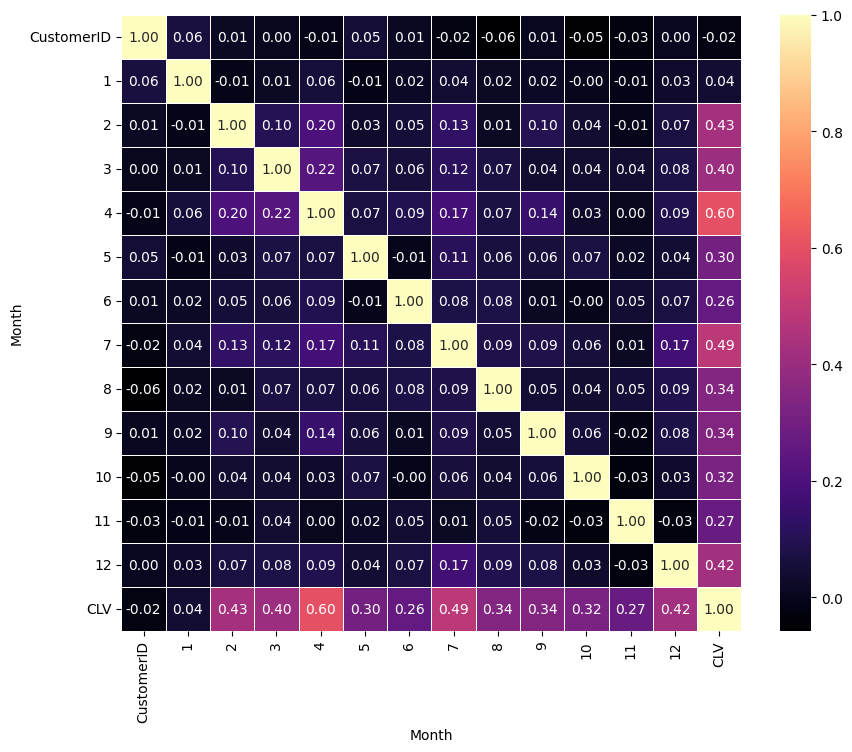

In [92]:
# Checking how much CLV is affected by each month sales
correlation_matrix = lvsales.corr()
plt.clf()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='magma', fmt=".2f", linewidths=0.5)
plt.show()

In [93]:
# Making categories from CLV
lvsales['clv_segment']=pd.qcut(sales2['CLV'],q=3, labels=False)
sales2.drop(columns='CLV', inplace=True)

In [94]:
lvsales

Month  CustomerID            1            2            3            4  \
0           12346      0.00000      0.00000      0.00000      0.00000   
1           12347      0.00000      0.00000   9541.06380      0.00000   
2           12348      0.00000      0.00000      0.00000      0.00000   
3           12350      0.00000      0.00000      0.00000      0.00000   
4           12356      0.00000      0.00000      0.00000      0.00000   
5           12359      0.00000      0.00000      0.00000      0.00000   
6           12370      0.00000      0.00000      0.00000      0.00000   
7           12373      0.00000      0.00000      0.00000      0.00000   
8           12377      0.00000      0.00000      0.00000      0.00000   
9           12383      0.00000      0.00000      0.00000      0.00000   
10          12386      0.00000      0.00000    507.83870      0.00000   
11          12388      0.00000      0.00000      0.00000      0.00000   
12          12393      0.00000      0.00000      0.00000      0.00000   
13          12395      0.00000    774.53192      0.00000      0.00000   
14          12402      0.00000      0.00000      0.00000      0.00000   
15          12410      0.00000      0.00000      0.00000      0.00000   
16          12413      0.00000      0.00000      0.00000      0.00000   
17          12414      0.00000      0.00000      0.00000      0.00000   
18          12415      0.00000      0.00000      0.00000      0.00000   
19          12417      0.00000      0.00000      0.00000      0.00000   
20          12421      0.00000      0.00000      0.00000      0.00000   
21          12422      0.00000      0.00000      0.00000      0.00000   
22          12423      0.00000      0.00000      0.00000      0.00000   
23          12427      0.00000    513.48048      0.00000      0.00000   
24          12429      0.00000      0.00000      0.00000   2732.54873   
25          12431   2646.77626      0.00000      0.00000      0.00000   
26          12433  12068.01749      0.00000      0.00000   5644.13667   
27          12434      0.00000      0.00000      0.00000      0.00000   
28          12437      0.00000      0.00000      0.00000      0.00000   
29          12441      0.00000      0.00000   1421.45868      0.00000   
30          12451      0.00000      0.00000      0.00000      0.00000   
31          12464      0.00000      0.00000      0.00000      0.00000   
32          12468      0.00000      0.00000      0.00000      0.00000   
33          12471     55.44560      0.00000      0.00000   6012.14031   
34          12472    881.20162   7073.33744      0.00000      0.00000   
35          12474      0.00000      0.00000    374.44000      0.00000   
36          12476      0.00000      0.00000      0.00000      0.00000   
37          12477      0.00000      0.00000      0.00000      0.00000   
38          12480      0.00000      0.00000      0.00000      0.00000   
39          12481      0.00000      0.00000      0.00000    893.07920   
40          12483      0.00000      0.00000      0.00000      0.00000   
41          12484      0.00000      0.00000      0.00000      0.00000   
42          12489      0.00000      0.00000      0.00000      0.00000   
43          12490      0.00000      0.00000      0.00000      0.00000   
44          12494      0.00000      0.00000      0.00000    149.70105   
45          12500      0.00000      0.00000      0.00000      0.00000   
46          12501      0.00000      0.00000      0.00000      0.00000   
47          12502      0.00000      0.00000      0.00000      0.00000   
48          12503      0.00000      0.00000      0.00000      0.00000   
49          12510      0.00000      0.00000      0.00000      0.00000   
50          12515      0.00000      0.00000      0.00000      0.00000   
51          12523      0.00000      0.00000      0.00000      0.00000   
52          12524      0.00000      0.00000      0.00000      0.00000   
53          12527      0.00000      0.00000      0.00000  

 Modelling

In [76]:
# Splitting the data in train and test
Y= lvsales['clv_segment']
X= lvsales.drop(columns=['CustomerID','clv_segment'])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=432)

In [77]:
# KNN

In [77]:
# Building KNN Model
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')
knn.fit(X_train, y_train)

import sklearn.metrics as metrics
print('Train roc_auc: ',metrics.roc_auc_score(y_train, knn.predict_proba(X_train),multi_class="ovr"))
print('Test roc_auc: ',metrics.roc_auc_score(y_test, knn.predict_proba(X_test),multi_class="ovr"))
print('Train accuracy: ',metrics.accuracy_score(y_train, knn.predict(X_train)))
print('Test accuracy: ',metrics.accuracy_score(y_test, knn.predict(X_test)))

Train roc_auc:  0.9936084755687257
Test roc_auc:  0.9732556218259997
Train accuracy:  0.9211295034079844
Test accuracy:  0.8979591836734694


In [82]:
# Support vector machine

In [78]:
# Building SVR Model
svc= SVC(C=100, gamma=0.0001, kernel='rbf', probability=True).fit(X_train, y_train)

print('Train roc_auc: ',metrics.roc_auc_score(y_train, svc.predict_proba(X_train),multi_class="ovr"))
print('Test roc_auc: ',metrics.roc_auc_score(y_test, svc.predict_proba(X_test),multi_class="ovr"))
print('Train accuracy: ',metrics.accuracy_score(y_train, svc.predict(X_train)))
print('Test accuracy: ',metrics.accuracy_score(y_test, svc.predict(X_test)))

Train roc_auc:  1.0
Test roc_auc:  0.9806737576113322
Train accuracy:  1.0
Test accuracy:  0.8412698412698413


In [387]:
# Random Forest

In [79]:
# Building Random Forest Model
rf = RandomForestClassifier(max_depth= 7, max_leaf_nodes= 50, min_samples_leaf= 5, min_samples_split= 10, n_estimators= 100)
rf.fit(X_train, y_train)

print('Train roc_auc: ',metrics.roc_auc_score(y_train, rf.predict_proba(X_train),multi_class="ovr"))
print('Test roc_auc: ',metrics.roc_auc_score(y_test, rf.predict_proba(X_test),multi_class="ovr"))
print('Train accuracy: ',metrics.accuracy_score(y_train, rf.predict(X_train)))
print('Test accuracy: ',metrics.accuracy_score(y_test, rf.predict(X_test)))

Train roc_auc:  0.9693743353568015
Test roc_auc:  0.9480292240014591
Train accuracy:  0.8734177215189873
Test accuracy:  0.8616780045351474


In [80]:
from sklearn.ensemble import GradientBoostingClassifier
gb= GradientBoostingClassifier(learning_rate=0.2, max_depth=8, min_samples_leaf=0.1, min_samples_split=0.1,n_estimators=50,subsample=1.0).fit(X_train, y_train)

print('Train roc_auc: ',metrics.roc_auc_score(y_train, gb.predict_proba(X_train),multi_class="ovr"))
print('Test roc_auc: ',metrics.roc_auc_score(y_test, gb.predict_proba(X_test),multi_class="ovr"))
print('Train accuracy: ',metrics.accuracy_score(y_train, gb.predict(X_train)))
print('Test accuracy: ',metrics.accuracy_score(y_test, gb.predict(X_test)))

Train roc_auc:  0.8845072837368549
Test roc_auc:  0.8651494417445508
Train accuracy:  0.7380720545277507
Test accuracy:  0.691609977324263


In [81]:
# XGBOOST
xgb_model0=XGBClassifier(colsample_bytree=0.6,
                        gamma=0.5, 
                        max_depth=3, 
                        min_child_weight=5, 
                        subsample=0.6).fit(X_train, y_train)


print('Train roc_auc: ',metrics.roc_auc_score(y_train, xgb_model0.predict_proba(X_train),multi_class="ovr"))
print('Test roc_auc: ',metrics.roc_auc_score(y_test, xgb_model0.predict_proba(X_test),multi_class="ovr"))
print('Train accuracy: ',metrics.accuracy_score(y_train, xgb_model0.predict(X_train)))
print('Test accuracy: ',metrics.accuracy_score(y_test, xgb_model0.predict(X_test)))

Train roc_auc:  0.9975482402752659
Test roc_auc:  0.9788310774451254
Train accuracy:  0.9629990262901655
Test accuracy:  0.9138321995464853


# 5. Cross-Selling (Which products are selling together)


By EDA

In [20]:
# Creating a copy of sales and taking only transaction numbers that are repeated
sales3= sales[sales['Transaction_ID'].duplicated(keep=False)]

In [21]:
# Joining all the products bought for each transaction
sales3['bundle']=sales3.groupby(by='Transaction_ID')['Product_SKU'].transform(lambda x: ','.join(x))
sales3=sales3[['Transaction_ID','bundle']].drop_duplicates()

In [22]:
# Using itertools and collections to find which cobinations are most common and how many times
from itertools import combinations
from collections import Counter
    
 # Function to get the top 10 most common combinations
def get_top_combinations(data, combination_size, top_n=10):
    count = Counter()
    for i in data:
        prod_list = i.split(',')
        count.update(Counter(combinations(prod_list, combination_size)))
    return pd.DataFrame(count.most_common(top_n), columns=['Combination', 'Count'])    
    
for j in [2, 3, 5]:
    print(f'Top 10 groups with {j} elements:')
    display(get_top_combinations(sales3['bundle'], j))   

Top 10 groups with 2 elements:


Combination  Count
0  (GGOENEBB078899, GGOENEBQ078999)    693
1  (GGOENEBJ079499, GGOENEBQ078999)    301
2  (GGOEGHGC019799, GGOEGHGR019499)    267
3  (GGOEGHGH019699, GGOEGHGT019599)    242
4  (GGOEGHGR019499, GGOEGHGT019599)    236
5  (GGOEGHGC019799, GGOEGHGT019599)    235
6  (GGOEGHGC019799, GGOEGHGH019699)    233
7  (GGOEGHGH019699, GGOEGHGR019499)    233
8  (GGOENEBB078899, GGOENEBJ079499)    228
9  (GGOENEBJ079499, GGOENEBQ079099)    226

Top 10 groups with 3 elements:


Combination  Count
0  (GGOEGHGC019799, GGOEGHGR019499, GGOEGHGT019599)    202
1  (GGOEGHGC019799, GGOEGHGH019699, GGOEGHGR019499)    201
2  (GGOEGHGH019699, GGOEGHGR019499, GGOEGHGT019599)    199
3  (GGOEGHGC019799, GGOEGHGH019699, GGOEGHGT019599)    188
4  (GGOENEBB078899, GGOENEBJ079499, GGOENEBQ078999)     85
5  (GGOENEBB078899, GGOENEBQ078999, GGOENEBQ079099)     65
6  (GGOENEBJ079499, GGOENEBQ078999, GGOENEBQ079099)     46
7  (GGOEGDHC018299, GGOEGDHR018499, GGOEGHGH019699)     38
8  (GGOENEBB078899, GGOENEBJ079499, GGOENEBQ079099)     37
9  (GGOEGDHC018299, GGOEGHGC019799, GGOEGHGR019499)     37

Top 10 groups with 5 elements:


Combination  Count
0  (GGOEGFSR022099, GGOEGHGC019799, GGOEGHGH01969...     25
1  (GGOEGDHC018299, GGOEGDHR018499, GGOEGHGH01969...     23
2  (GGOEGDHC018299, GGOEGHGC019799, GGOEGHGH01969...     23
3  (GGOEAKDH019899, GGOEGHGC019799, GGOEGHGH01969...     23
4  (GGOEGDHC018299, GGOEGDHR018499, GGOEGHGC01979...     21
5  (GGOEGDHC018299, GGOEGDHR018499, GGOEGHGC01979...     20
6  (GGOEGDHC018299, GGOEGDHR018499, GGOEGHGC01979...     20
7  (GGOEGBMJ013399, GGOEGHGC019799, GGOEGHGH01969...     18
8  (GGOEGDHR018499, GGOEGHGC019799, GGOEGHGH01969...     18
9  (GGOEGFYQ016599, GGOEGHGC019799, GGOEGHGH01969...     18

By using distance

In [48]:
# Creating list of products and making a pivot table between product and transaction
list_products = list(set(sales.Product_SKU))
cust_prod=sales.pivot_table(index='Product_SKU', columns='Transaction_ID', values='CustomerID', aggfunc='count').fillna(0)

In [49]:
# Finding distance between each set of product and storing it in a dataframe
prod_prod_similarity= pairwise_distances(cust_prod, metric='euclidean')
prod_prod_similarity = pd.DataFrame(prod_prod_similarity, columns =list_products, index= list_products )
prod_prod_similarity

GGOEGALQ034217  GGOEYAQB073214  GGOEGOCD078399  \
GGOEGALQ034217        0.000000        5.830952        7.681146   
GGOEYAQB073214        5.830952        0.000000        7.141428   
GGOEGOCD078399        7.681146        7.141428        0.000000   
GGOEYAEB035614        6.855655        6.855655        8.485281   
GGOEYAEB035615        6.164414        6.000000        7.810250   
GGOEGAWR061050        5.196152        5.196152        7.211103   
GGOEGAXB089255        5.744563        5.196152        7.745967   
GGOEGAAJ080615        8.124038        8.246211        9.219544   
GGOEGBJC019999        6.480741        6.633250        8.306624   
GGOEYAAB034616        6.000000        6.164414        7.937254   
GGOEYAEJ029017        6.633250        6.633250        8.306624   
GGOEAAWC061653        5.567764        5.196152        7.483315   
GGOEGAER033214        6.403124        6.244998        7.874008   
GGOEYAAB034617        7.549834        7.681146        9.055385   
GGOEGOCB078299        6.000000        6.164414        7.549834   
GGOENEBD084799        5.385165        5.567764        7.483315   
GGOEGHPB003410        4.898979        5.099020        7.141428   
GGOEGAWC061254        5.385165        5.567764        7.483315   
GGOEGAEQ027917        5.099020        5.291503        7.280110   
GGOEGAWN062749        5.291503        5.477226        7.416198   
GGOEGAAJ032815        4.690416        4.898979        7.000000   
GGOEGAEJ033316        4.690416        4.690416        7.000000   
GGOEGATC060317        5.567764        5.744563        7.483315   
GGOEGAWH061354        5.385165        5.385165        7.348469   
GGOEAAXN066329        4.690416        4.898979        7.000000   
GGOEGAER090414        4.358899        4.582576        6.782330   
GGOEYAEA035114        6.782330        6.928203        8.426150   
GGOEGAXR065155        7.615773        7.615773        9.110434   
GGOEAAEJ033415        7.211103        7.348469        8.888194   
GGOEAAAL081116        5.291503        5.477226        7.416198   
GGOEGAEJ030816        6.557439        6.708204        8.366600   
GGOEAFKA087599        6.633250        6.633250        8.306624   
GGOEYALQ091914        6.000000        6.164414        7.937254   
GGOEGAAQ010416        5.567764        5.744563        7.615773   
GGOEGBMB073599        5.099020        5.291503        7.280110   
GGOEGAEB084516        4.795832        5.000000        7.071068   
GGOENEBQ093499        5.567764        5.567764        7.615773   
GGOEGAPB058614        5.916080        6.082763        7.874008   
GGOEGBMJ013399        5.744563        5.916080        7.745967   
GGOEGDHJ023099        6.082763        6.244998        8.000000   
GGOEGAET090513        4.582576        4.795832        6.928203   
GGOEAAEH035215        4.123106        4.358899        6.633250   
GGOEGAAL059015        4.358899        4.582576        6.782330   
GGOEYAFB073116        4.242641        4.472136        6.708204   
GGOEGAAJ080617        4.123106        4.358899        6.633250   
GGOEGAEJ028917        5.000000        5.196152        7.211103   
GGOEGAEB027814        6.403124        6.557439        8.124038   
GGOEAAAB081016        5.656854        5.830952        7.681146   
GGOEAAAB081014        5.744563        5.916080        7.745967   
GGOEGALB036514        5.196152        5.385165        7.348469   
GGOEGAXB089230        6.633250        6.633250        8.306624   
GGOEGALB034113        7.745967        7.745967        9.219544   
GGOEGAAJ059115        6.557439        6.708204        8.366600   
GGOEAHPJ004213        5.196152        5.385165        7.348469   
GGOEAAAB034915        5.385165        5.567764        7.483315   
GGOEAAWC061648        5.830952        5.830952        7.810250   
GGOEGALP036315        7.000000        7.141428        8.717798   
GGOEGADJ056818        5.477226        5.656854        7.549834   
GGOEGADB056913        5.830952        6.000000        7.810250   
GGOEAAEJ035714        5.291503        5.477226        7.

In [53]:
# Top 10 similar products for each products
top_10_similar_products=pd.DataFrame(index=list_products,columns=['P1','P2','P3','P4','P5','P6','P7','P8','P9','P10'])
for i in prod_prod_similarity:
    l=list([prod_prod_similarity[i].sort_values()[1:11].index])
    for j,k in enumerate(['P1','P2','P3','P4','P5','P6','P7','P8','P9','P10']):
        top_10_similar_products.loc[i,k]=l.__getitem__(0).__getitem__(j)

In [54]:
top_10_similar_products

P1              P2              P3  \
GGOEGALQ034217  GGOEGCKQ084999  GGOEGAYH068424  GGOEGAEQ027915   
GGOEYAQB073214  GGOEGAAJ032814  GGOEYAWJ061448  GGOEGAAJ080617   
GGOEGOCD078399  GGOEYAEJ029016  GGOEGADJ059714  GGOEGAAJ080617   
GGOEYAEB035614  GGOEYAAJ033015  GGOEGCKQ084999  GGOEYAEJ092116   
GGOEYAEB035615  GGOEYAAJ033015  GGOEGAYH068424  GGOEGCKQ084999   
GGOEGAWR061050  GGOEGAAJ057018  GGOEGAEJ031314  GGOEWAAJ083516   
GGOEGAXB089255  GGOEYAAJ033015  GGOEGAYH068424  GGOEGCKQ084999   
GGOEGAAJ080615  GGOEGCKQ084999  GGOEGAWR061048  GGOENEBQ092299   
GGOEGBJC019999  GGOEYOCR078099  GGOEGCKQ084999  GGOEYAAJ033015   
GGOEYAAB034616  GGOEYAAJ033015  GGOEGAYH068424  GGOEGCKQ084999   
GGOEYAEJ029017  GGOEGAEJ031314  GGOEYOCR077399  GGOEGAER090414   
GGOEAAWC061653  GGOEYAAJ033015  GGOEGAYH068424  GGOEGCKQ084999   
GGOEGAER033214  GGOEYAAJ033015  GGOEGAYH068424  GGOEGCKQ084999   
GGOEYAAB034617  GGOEGDHQ086199  GGOEGAEQ027915  GGOEGAWC061250   
GGOEGOCB078299  GGOEGAAJ057017  GGOEGAPC058814  GGOEGALL060013   
GGOENEBD084799  GGOEGAEB031516  GGOEGAWR061048  GGOEGAFB035813   
GGOEGHPB003410  GGOEYAAJ033015  GGOEGCKQ084999  GGOEYAEJ092116   
GGOEGAWC061254  GGOEYAEJ092116  GGOEAAEH035215  GGOEAAXN066355   
GGOEGAEQ027917  GGOEYAAJ033015  GGOEYAEJ092116  GGOEAAXN066355   
GGOEGAWN062749  GGOEGAPC058814  GGOEAAEH035215  GGOEGATB060615   
GGOEGAAJ032815  GGOEGAAJ080617  GGOEGAYH068424  GGOEGAEB031516   
GGOEGAEJ033316  GGOEYAAJ033015  GGOEGCKQ084999  GGOEGAYH068424   
GGOEGATC060317  GGOEYAEJ029016  GGOEAAAB034916  GGOEGAAJ032814   
GGOEGAWH061354  GGOEYAFB073116  GGOEGAWR061048  GGOEGAWC061250   
GGOEAAXN066329  GGOEYAAJ033015  GGOEGAYH068424  GGOEGCKQ084999   
GGOEGAER090414  GGOEYAAJ033015  GGOEGAYH068424  GGOEGCKQ084999   
GGOEYAEA035114  GGOEGATB060615  GGOEGAYB068025  GGOEGCKQ084999   
GGOEGAXR065155  GGOEGCBQ016499  GGOEGAYB068025  GGOEGDHQ086199   
GGOEAAEJ033415  GGOEGAYH068424  GGOEGAEQ027915  GGOEGALL060013   
GGOEAAAL081116  GGOEYAAJ033015  GGOEGCKQ084999  GGOEYAEJ092116   
GGOEGAEJ030816  GGOEGAAJ057018  GGOEYAEJ029016  GGOEAAWC062450   
GGOEAFKA087599  GGOEGAPC058814  GGOEAAEH035215  GGOEYAWJ061448   
GGOEYALQ091914  GGOEGCKQ084999  GGOEGAEQ027915  GGOEYAWJ061448   
GGOEGAAQ010416  GGOEGAPC058814  GGOEAAAJ080814  GGOEYAWJ061448   
GGOEGBMB073599  GGOEGAAJ057018  GGOEGAAJ080617  GGOEGCKQ084999   
GGOEGAEB084516  GGOEGAEJ031314  GGOEAAAB034916  GGOEGAER090414   
GGOENEBQ093499  GGOEYAAJ033015  GGOEGAYH068424  GGOEGCKQ084999   
GGOEGAPB058614  GGOEYAWJ061448  GGOEGAPC058814  GGOEGCKQ084999   
GGOEGBMJ013399  GGOEYAAJ033015  GGOEGAYH068424  GGOEGCKQ084999   
GGOEGDHJ023099  GGOEYAAJ033015  GGOEGAYH068424  GGOEGCKQ084999   
GGOEGAET090513  GGOEYAAJ033015  GGOEGAYH068424  GGOEGCKQ084999   
GGOEAAEH035215  GGOEYAAJ033015  GGOEGAYH068424  GGOEGCKQ084999   
GGOEGAAL059015  GGOEAAEH035215  GGOEYAAJ033015  GGOEGCKQ084999   
GGOEYAFB073116  GGOEYAEJ033514  GGOEGAYH068424  GGOEGCKQ084999   
GGOEGAAJ080617  GGOEYAAJ033015  GGOEYAEJ092116  GGOEGCKQ084999   
GGOEGAEJ028917  GGOEYAAJ033015  GGOEGAYH068424  GGOEGCKQ084999   
GGOEGAEB027814  GGOEYAAJ033015  GGOEGAYH068424  GGOEGCKQ084999   
GGOEAAAB081016  GGOEGARJ058415  GGOEGAYH068424  GGOEYAAJ033015   
GGOEAAAB081014  GGOEGARJ058415  GGOEGAXT065429  GGOEGAAJ080617   
GGOEGALB036514  GGOEGAAJ032815  GGOEGAYH068424  GGOEGCKQ084999   
GGOEGAXB089230  GGOEGAEJ033316  GGOEYAEJ092116  GGOEGCMB020932   
GGOEGALB034113  GGOEGAWC061250  GGOEGAAJ080614  GGOEGCMB020932   
GGOEGAAJ059115  GGOEYAFB073116  GGOEYAEJ033514  GGOEGCKQ084999   
GGOEAHPJ004213  GGOEAAXN066329  GGOEGAAJ057014  GGOEGAXP089355   
GGOEAAAB034915  GGOEGAAJ057018  GGOEGAEC033115  GGOEGCKQ084999   
GGOEAAWC061648  GGOEYAAJ033015  GGOEGCKQ084999  GGOEGAYH068424   
GGOEGALP036315  GGOEGALL060014  GGOEGAAJ032814  GGOEYAEJ029016   
GGOEGADJ056818  GGOEGAPC058814  GGOEGAXQ067130  GGOEGARJ058415   
GGOEGADB056913  GGOEYAAJ033015  GGOEGCKQ084999  GGOEGAYH068424   
GGOEAAEJ035714  GGOEGAEJ031314  GGOEAFKA087499  GGOEGAER090414   
GG

In [28]:
# Creating a binary matrix indicating whether a product was bought in a transaction
basket_data = pd.pivot_table(sales, index='Transaction_ID', columns='Product_SKU', values='Quantity', aggfunc='sum', fill_value=0)

# For market basket analysis, we don't need the quantities, just whether the product was bought or not
basket_data = basket_data.applymap(lambda x: 1 if x > 0 else 0)

basket_data

Product_SKU     GGOEA0CH077599  GGOEAAAB034813  GGOEAAAB034814  \
Transaction_ID                                                   
16679                        0               0               0   
16680                        0               0               0   
16681                        0               0               0   
16682                        0               0               0   
16684                        0               0               0   
...                        ...             ...             ...   
48493                        0               0               0   
48494                        0               0               0   
48495                        0               0               0   
48496                        0               0               0   
48497                        0               0               0   

Product_SKU     GGOEAAAB034815  GGOEAAAB034816  GGOEAAAB034817  \
Transaction_ID                                                   
16679                        0               0               0   
16680                        0               0               0   
16681                        0               0               0   
16682                        0               0               0   
16684                        0               0               0   
...                        ...             ...             ...   
48493                        0               0               0   
48494                        0               0               0   
48495                        0               0               0   
48496                        0               0               0   
48497                        0               0               0   

Product_SKU     GGOEAAAB034913  GGOEAAAB034914  GGOEAAAB034915  \
Transaction_ID                                                   
16679                        0               0               0   
16680                        0               0               0   
16681                        0               0               0   
16682                        0               0               0   
16684                        0               0               0   
...                        ...             ...             ...   
48493                        0               0               0   
48494                        0               0               0   
48495                        0               0               0   
48496                        0               0               0   
48497                        0               0               0   

Product_SKU     GGOEAAAB034916  ...  GGOEYHPA003510  GGOEYHPA003610  \
Transaction_ID                  ...                                   
16679                        0  ...               0               0   
16680                        0  ...               0               0   
16681                        0  ...               0               0   
16682                        0  ...               0               0   
16684                        0  ...               0               0   
...                        ...  ...             ...             ...   
48493                        0  ...               0               0   
48494                        0  ...               0               0   
48495                        0  ...               0               0   
48496                        0  ...               0               0   
48497                        0  ...               0               0   

Product_SKU     GGOEYHPB072210  GGOEYOBR078599  GGOEYOCB092699  \
Transaction_ID                                                   
16679                        0               0               0   
16680                        0               0               0   
16681                        0               0               0   
16682                        0               0               0   
16684                        0               0               0   
...                        ...       

Market Basket Analysis

In [46]:
from mlxtend.frequent_patterns import apriori, association_rules

# Apply the Apriori algorithm to find frequent itemsets with a minimum support of 0.01
frequent_itemsets = apriori(basket_data, min_support=0.01, use_colnames=True)

# View the frequent itemsets
print(frequent_itemsets)

rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1, num_itemsets=None)
rules

C:\Users\User.DESKTOP-C8S3NG8.000\anaconda3\envs\notebook-7.2.2\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


     support                          itemsets
0   0.010295                  (GGOEAFKQ020499)
1   0.015203                  (GGOEAKDH019899)
2   0.016280                  (GGOEGBMJ013399)
3   0.023263                  (GGOEGDHC018299)
4   0.016280                  (GGOEGDHQ015399)
5   0.012729                  (GGOEGDHR018499)
6   0.012569                  (GGOEGDWR015799)
7   0.032162                  (GGOEGFKQ020399)
8   0.012769                  (GGOEGFKQ020799)
9   0.011213                  (GGOEGFSR022099)
10  0.011652                  (GGOEGFYQ016599)
11  0.014924                  (GGOEGGOA017399)
12  0.017677                  (GGOEGHGC019799)
13  0.015482                  (GGOEGHGH019699)
14  0.014644                  (GGOEGHGR019499)
15  0.012968                  (GGOEGHGT019599)
16  0.021787                  (GGOEGHPB071610)
17  0.010534                  (GGOEGHPJ080310)
18  0.011173                  (GGOEGOAQ012899)
19  0.012928                  (GGOEGOAQ020099)
20  0.015083 

antecedents       consequents  antecedent support  consequent support  \
0  (GGOEGHGC019799)  (GGOEGHGR019499)            0.017677            0.014644   
1  (GGOEGHGR019499)  (GGOEGHGC019799)            0.014644            0.017677   
2  (GGOENEBB078899)  (GGOENEBQ078999)            0.128886            0.132796   
3  (GGOENEBQ078999)  (GGOENEBB078899)            0.132796            0.128886   

    support  confidence       lift  representativity  leverage  conviction  \
0  0.010654    0.602709  41.156636               1.0  0.010395    2.480185   
1  0.010654    0.727520  41.156636               1.0  0.010395    3.605126   
2  0.027653    0.214551   1.615644               1.0  0.010537    1.104087   
3  0.027653    0.208233   1.615644               1.0  0.010537    1.100216   

   zhangs_metric   jaccard  certainty  kulczynski  
0       0.993260  0.491713   0.596804    0.665115  
1       0.990203  0.491713   0.722617    0.665115  
2       0.437430  0.118159   0.094274    0.211392  
3       0.439403  0.118159   0.091088    0.211392

In [90]:
# Example: Top 10 similar products for product_sku GGOEGAEJ028113
top_10_similar_products[top_10_similar_products.index=='GGOEGAEJ028113']

P1              P2              P3  \
GGOEGAEJ028113  GGOEGALL060016  GGOEGAYH067925  GGOEA0CH077599   

                            P4              P5              P6  \
GGOEGAEJ028113  GGOEAAAJ031913  GGOEGARJ058415  GGOEGAWQ062248   

                            P7              P8              P9             P10  
GGOEGAEJ028113  GGOEGADB059613  GGOEGADJ059813  GGOEGAUC057715  GGOEGAFB035815

In [51]:
b = basket_data.sum()
sorted_basket = b.sort_values(ascending=False)

In [42]:
pd.set_option('display.max_rows', 1500)

In [52]:
sorted_basket

Product_SKU
GGOENEBJ079499    3511
GGOENEBQ078999    3328
GGOENEBB078899    3230
GGOENEBQ079099    1361
GGOENEBQ084699    1089
GGOENEBQ079199    1065
GGOENEBQ086799     844
GGOEGFKQ020399     806
GGOENEBQ086499     599
GGOEGDHC018299     583
GGOEGHPB071610     546
GGOENEBQ092299     498
GGOEGHGC019799     443
GGOEYFKQ020699     419
GGOEGBMJ013399     408
GGOEGDHQ015399     408
GGOENEBD084799     393
GGOEGHGH019699     388
GGOEAKDH019899     381
GGOEGOLC014299     378
GGOEGGOA017399     374
GGOEGHGR019499     367
GGOEGHGT019599     325
GGOEGOAQ020099     324
GGOEGFKQ020799     320
GGOEGDHR018499     319
GGOEGDWR015799     315
GGOEGFYQ016599     292
GGOEGFSR022099     281
GGOEGOAQ012899     280
GGOEGHPJ080310     264
GGOEAFKQ020499     258
GGOEGOXQ016399     255
GGOEADWQ015699     250
GGOEGDHC074099     250
GGOEGOCB017499     220
GGOEGAAH034015     216
GGOEGBJL013999     213
GGOEAFKQ020599     206
GGOEGBJC019999     204
GGOEGFKA022299     188
GGOEGAAB033814     186
GGOEYHPB072210     182

From the analysis above, we can see that there are only 6 products that range in the quantities of thousands that were bought.
There are 86 products that range in the hundreds that were bought.
The number of unique products that are there are 1145.

In [138]:
rules.sort_values(by='confidence', ascending=False )

antecedents       consequents  antecedent support  consequent support  \
1  (GGOEGHGR019499)  (GGOEGHGC019799)            0.014644            0.017677   
0  (GGOEGHGC019799)  (GGOEGHGR019499)            0.017677            0.014644   
3  (GGOENEBB078899)  (GGOENEBQ078999)            0.128886            0.132796   
2  (GGOENEBQ078999)  (GGOENEBB078899)            0.132796            0.128886   

    support  confidence       lift  representativity  leverage  conviction  \
1  0.010654    0.727520  41.156636               1.0  0.010395    3.605126   
0  0.010654    0.602709  41.156636               1.0  0.010395    2.480185   
3  0.027653    0.214551   1.615644               1.0  0.010537    1.104087   
2  0.027653    0.208233   1.615644               1.0  0.010537    1.100216   

   zhangs_metric   jaccard  certainty  kulczynski  
1       0.990203  0.491713   0.722617    0.665115  
0       0.993260  0.491713   0.596804    0.665115  
3       0.437430  0.118159   0.094274    0.211392  
2       0.439403  0.118159   0.091088    0.211392

6. Predicting Next Purchase Day(How soon each customer can visit the store (0-30 days, 30-60
days, 60-90 days, 90+ days)
• For this, we need create dependent variable at customer level (average days per one
transaction for only repeat customers and divide into groups 0-30 days, 30-60 days,
60-90 days and 90+ days) then build classification model to predict next purchase of
given customer.

In [27]:
customer360['Average_trans_days']=customer360['Tenure_days']/customer360['Total_orders']

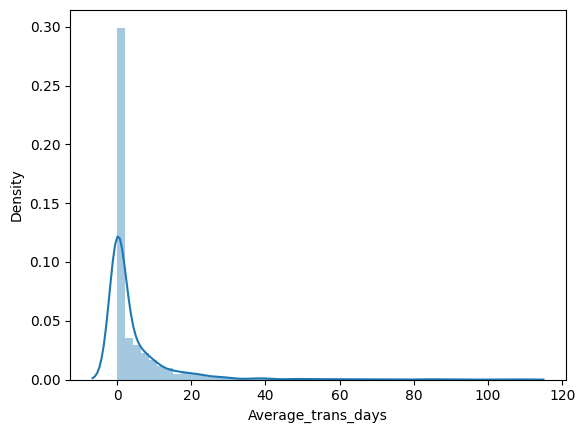

In [100]:
plt.clf()
sns.distplot(customer360['Average_trans_days'])
plt.show()

30 days gap is not working because only 23 records are above 30 days, so we'll use 20 days

In [53]:
customer360['Next_purchase_segment']= np.where(customer360.Average_trans_days<=20,0,
                                               np.where(customer360.Average_trans_days<=40,1,
                                                       np.where(customer360.Average_trans_days<=60,2,3)))

In [54]:
# Splitting the data in train and test
Y= customer360['Next_purchase_segment']
X= customer360.drop(columns=['Next_purchase_segment','CustomerID'])
X=pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=432)

In [55]:
# Outlier treatment
def outlier(x):
    if (x.dtype=='int64')|(x.dtype=='float64'):
        x.clip(upper = x.quantile(0.99), lower = x.quantile(0.01) )
    return x

X_train = X_train.apply(outlier)
X_test = X_test.apply(outlier)

In [56]:
# Standardization of data
from sklearn.preprocessing import MinMaxScaler
scaler= MinMaxScaler().fit(X_train)
x_train_std=pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
x_test_std=pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [57]:
# Balancing the dataset
from imblearn.over_sampling import SMOTE
smt= SMOTE(k_neighbors=1)
x_train_final, y_train_final= smt.fit_resample(x_train_std, y_train)

Modelling

In [26]:
# Logistic Regression model
from sklearn.linear_model import LogisticRegression
ln_model= LogisticRegression().fit(x_train_std, y_train)
print(metrics.classification_report(y_train_final, ln_model.predict(x_train_final)))
print(metrics.classification_report(y_test, ln_model.predict(x_test_std)))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67       971
           1       0.04      0.09      0.06       971
           2       0.00      0.00      0.00       971
           3       0.00      0.00      0.00       971

    accuracy                           0.27      3884
   macro avg       0.14      0.27      0.18      3884
weighted avg       0.14      0.27      0.18      3884

              precision    recall  f1-score   support

           0       0.95      1.00      0.98       415
           1       0.00      0.00      0.00        21
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         4

    accuracy                           0.94       441
   macro avg       0.24      0.25      0.24       441
weighted avg       0.90      0.94      0.92       441



In [110]:
# KNNClassifier model
from sklearn.neighbors import KNeighborsClassifier
ln_model= KNeighborsClassifier(n_neighbors=5, weights='uniform').fit(x_train_std, y_train)
print(metrics.classification_report(y_train, ln_model.predict(x_train_std)))
print(metrics.classification_report(y_test, ln_model.predict(x_test_std)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       971
           1       0.79      0.46      0.58        41
           2       0.86      0.55      0.67        11
           3       0.00      0.00      0.00         4

    accuracy                           0.97      1027
   macro avg       0.66      0.50      0.56      1027
weighted avg       0.96      0.97      0.96      1027

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       415
           1       0.33      0.05      0.08        21
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         4

    accuracy                           0.94       441
   macro avg       0.32      0.26      0.26       441
weighted avg       0.91      0.94      0.92       441



In [58]:
# #Decision tree classifier

 #Finding the best parameters for decision tree classifier
dt_param={'criterion':['gini','entropy'], 
          'max_depth':range(4,10), 
          'min_samples_leaf':range(1,5),
          'min_samples_split':range(4,9)}

dt_grid= GridSearchCV(DecisionTreeClassifier(), param_grid=dt_param, verbose=True).fit(x_train_final, y_train_final)
dt_grid.best_params_

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


{'criterion': 'gini',
 'max_depth': 4,
 'min_samples_leaf': 1,
 'min_samples_split': 4}

In [59]:
# Building the decision tree model
dt_model= DecisionTreeClassifier(criterion='gini', 
                                 max_depth=4, 
                                 min_samples_leaf=1, 
                                 min_samples_split=4).fit(x_train_final, y_train_final)
print(metrics.classification_report(y_train_final, dt_model.predict(x_train_final)))
print(metrics.classification_report(y_test, dt_model.predict(x_test_std)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       971
           1       1.00      1.00      1.00       971
           2       1.00      1.00      1.00       971
           3       1.00      1.00      1.00       971

    accuracy                           1.00      3884
   macro avg       1.00      1.00      1.00      3884
weighted avg       1.00      1.00      1.00      3884

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       415
           1       1.00      1.00      1.00        21
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         4

    accuracy                           1.00       441
   macro avg       1.00      1.00      1.00       441
weighted avg       1.00      1.00      1.00       441



In [ ]:
# # XGBOOST
# Finding the best parameters for XGBOOST Model
xg_params = {
         'min_child_weight': [1, 5, 10],
         'gamma': [0.5, 1, 1.5, 2, 5],
         'subsample': [0.6, 0.8, 1.0],
         'colsample_bytree': [0.6, 0.8, 1.0],
         'max_depth': [3, 4, 5]
         }

xg_grid=GridSearchCV(XGBClassifier(), param_grid=xg_params, verbose=2, n_jobs=-1, random_state=42).fit(x_train_final, y_train_final)
xg_grid.best_params_

In [91]:
# Building the XGBOOST model
xgb_model=XGBClassifier(colsample_bytree=0.6,
                        gamma=0.5, 
                        max_depth=3, 
                        min_child_weight=5, 
                        subsample=0.6).fit(x_train_final, y_train_final)
print(metrics.classification_report(y_train_final, xgb_model.predict(x_train_final)))
print(metrics.classification_report(y_test, xgb_model.predict(x_test_std)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       971
           1       1.00      1.00      1.00       971
           2       1.00      1.00      1.00       971
           3       1.00      1.00      1.00       971

    accuracy                           1.00      3884
   macro avg       1.00      1.00      1.00      3884
weighted avg       1.00      1.00      1.00      3884

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       415
           1       0.87      0.95      0.91        21
           2       0.50      1.00      0.67         1
           3       1.00      1.00      1.00         4

    accuracy                           0.99       441
   macro avg       0.84      0.99      0.89       441
weighted avg       0.99      0.99      0.99       441



In [115]:
# The original dataset is higly imbalanced so it's hard to evaluate results
# From the results we got, we can say that decision tree and XGBOOST are giving best results

# 7.Perform cohort analysis by defining below cohorts


• Customers who started in each month and understand their behaviour

In [30]:
# Revenue generated by customers for each starting month for every monnth of their tenure
sales.groupby(by=['Start_month','cohort_index'])['Invoice_amount'].sum().unstack()

cohort_index            0            1            2             3   \
Start_month                                                          
1             460087.03245  40930.36168  46466.73453  122337.23819   
2             283400.30552   7966.85419  14255.26374   22379.17552   
3             276490.38271  44298.34483  36295.51296   26763.95473   
4             261083.53827  23500.60912  14655.69291   33207.92071   
5             200413.41288   5979.74274  13981.91949   15570.71168   
6             170882.56280  12483.72820  13607.65848   14287.09435   
7             166792.62243  14588.46584   6142.65699   15568.93351   
8             199470.65440   8945.31778  11870.74636   26818.67760   
9             131400.65575   2071.49076   2409.07240     555.48589   
10            240347.30434   9127.57840   2393.11455           NaN   
11            204083.30768   3958.40111          NaN           NaN   
12            208271.93961          NaN          NaN           NaN   

cohort_index           4            5            6            7            8   \
Start_month                                                                     
1             31049.25888  47545.32956  93402.70685  52643.63840  36613.40169   
2             21297.96797  47759.28310  24687.19848  39592.50513  18180.78065   
3             52156.02683  69201.55112  42217.36581  42873.61397  23325.96368   
4             25929.29344  26078.26824  17012.00412  52405.94632  15428.39444   
5             14770.95624  40051.73964  35518.69872   9616.50413          NaN   
6             11319.12640  35013.69928  13034.08972          NaN          NaN   
7             22082.68728  24101.46249          NaN          NaN          NaN   
8             13806.27058          NaN          NaN          NaN          NaN   
9                     NaN          NaN          NaN          NaN          NaN   
10                    NaN          NaN          NaN          NaN          NaN   
11                    NaN          NaN          NaN          NaN          NaN   
12                    NaN          NaN          NaN          NaN          NaN   

cohort_index           9            10          11  
Start_month                                         
1             49643.37380  37737.90840  77999.8071  
2             26958.65760  39560.72662         NaN  
3             30803.83391          NaN         NaN  
4                     NaN          NaN         NaN  
5                     NaN          NaN         NaN  
6                     NaN          NaN         NaN  
7                     NaN          NaN         NaN  
8                     NaN          NaN         NaN  
9                     NaN          NaN         NaN  
10                    NaN          NaN         NaN  
11                    NaN          NaN         NaN  
12                    NaN          NaN         NaN

In [40]:
# Additional analysis for customers starting for different months
ad=sales.groupby(by=['Start_month'])['Invoice_amount'].sum().reset_index()
ad['Invoice_amount'] = ad['Invoice_amount'].apply(lambda x: f'{x:,.2f}')
ad

Start_month Invoice_amount
0             1   1,096,456.79
1             2     546,038.72
2             3     644,426.55
3             4     469,301.67
4             5     335,903.69
5             6     270,627.96
6             7     249,276.83
7             8     260,911.67
8             9     136,436.70
9            10     251,868.00
10           11     208,041.71
11           12     208,271.94

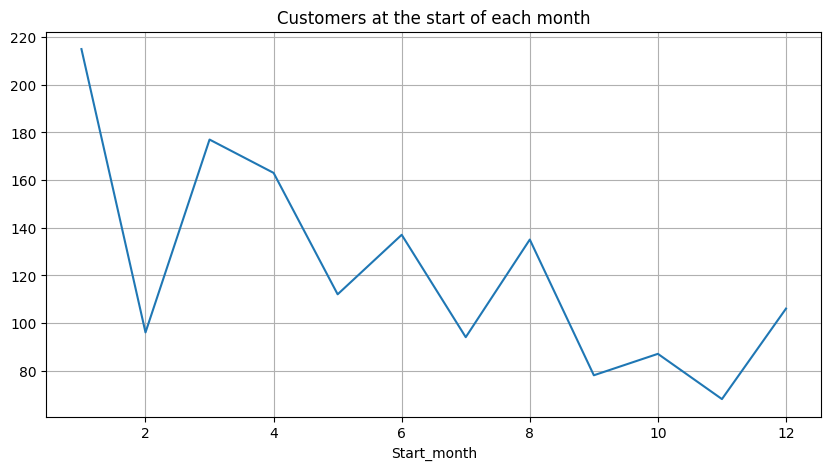

In [47]:
#Customers during the start of each month
plt.figure(figsize=(10,5))
sc = sales.groupby(by = 'Start_month')['CustomerID'].nunique()
sc.plot(kind='line')
plt.title('Customers at the start of each month')
plt.grid(True)
plt.show()


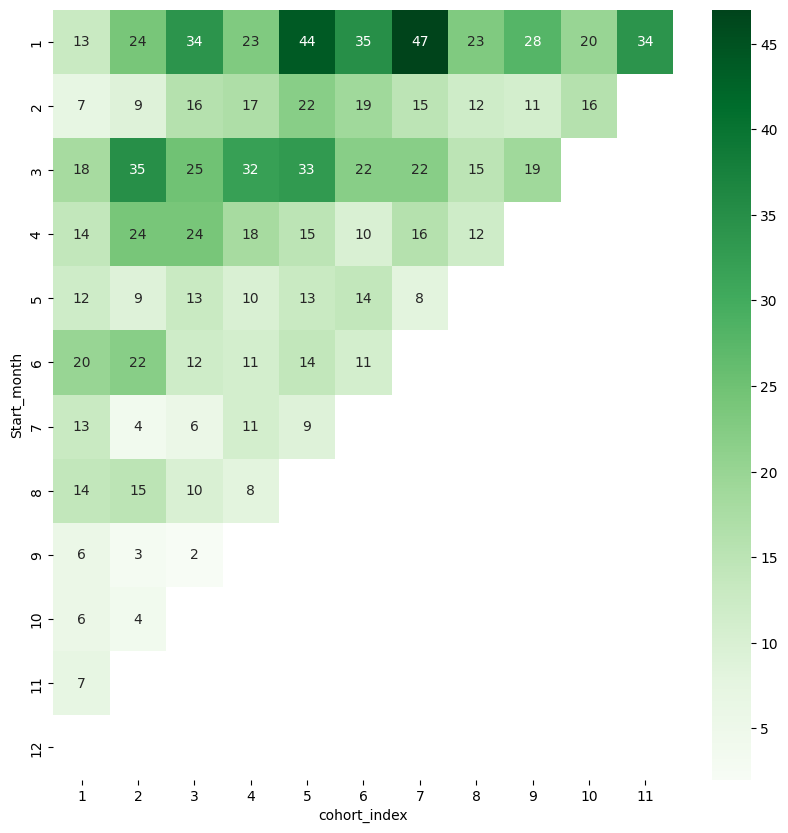

In [41]:
# Numbers of customer retained for each starting month for each cohert_index
plt.figure(figsize=(10,10))
sns.heatmap(sales.groupby(by=['Start_month','cohort_index'])['CustomerID'].nunique().unstack().loc[:,1:], annot=True, cmap='Greens')
plt.show()

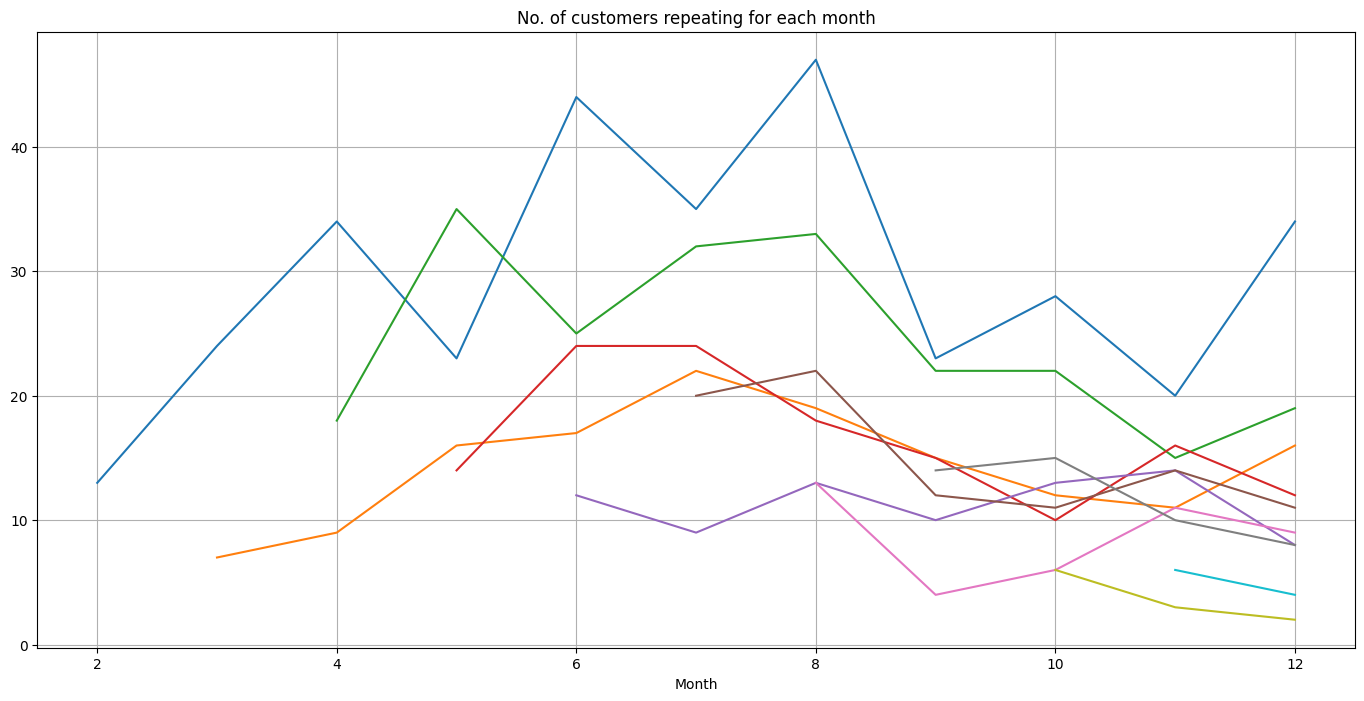

In [43]:
#Trend of Number of customers for each month
plt.figure(figsize=(17,8))
plt.title('No. of customers repeating for each month')
for i in range(1,13):    
    a=sales[sales['Start_month']==i].groupby(by='Month').nunique()['CustomerID']
    a[1:].plot(kind='line')

plt.grid()
plt.show()


 • Which Month cohort has maximum retention?

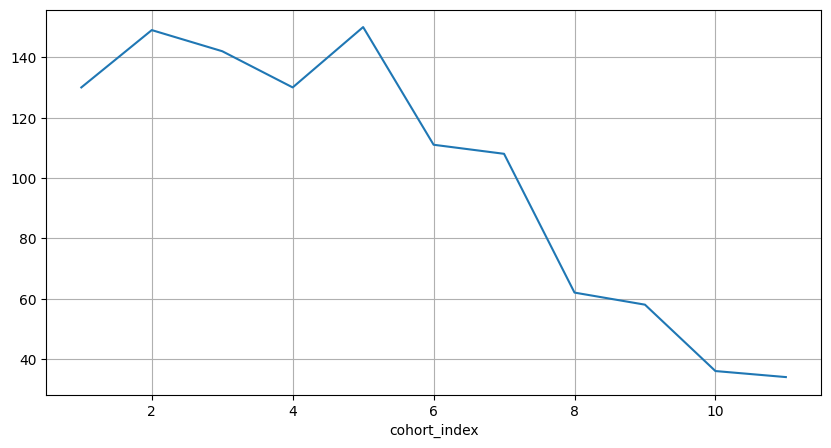

cohort_index
0     1468.0
1      130.0
2      149.0
3      142.0
4      130.0
5      150.0
6      111.0
7      108.0
8       62.0
9       58.0
10      36.0
11      34.0
dtype: float64

In [48]:
# How many months most customers lasted??
plt.figure(figsize=(10,5))
sales.groupby(by=['Start_month','cohort_index'])['CustomerID'].nunique().unstack().sum()[1:]
plt.ticklabel_format(style='plain',axis='y')
plt.grid(True)
plt.show()
s = sales.groupby(by=['Start_month','cohort_index'])['CustomerID'].nunique().unstack().sum()
s

 We can see that overall most customers stayed for
 5 months- 150 customers
 2 months- 149 customers
 3 months- 142 customers

In [60]:
    # Best retaining cohort_index for customer starting in each month
a=sales.groupby(by=['Start_month','cohort_index'])['CustomerID'].nunique().unstack().loc[:,1:]
best_cohort_index=pd.DataFrame()
b={}
for i in range(1,12):
    c=a[a.index==i][a[a.index==i]==a[a.index==i].max(axis=1)[i]].dropna(axis=1).columns.values.__getitem__(0)
    b[i]=[c]
best_cohort_index.rename(columns={0:'Best_cohort_index'}, inplace=True)

z=pd.DataFrame(b).T.reset_index()
z.rename(columns={'index':'Starting_month',0:'Best_retaining_index'}, inplace=True)
z.set_index('Starting_month', inplace=True)
display(z)

Best_retaining_index
Starting_month                      
1                                  7
2                                  5
3                                  2
4                                  2
5                                  6
6                                  2
7                                  1
8                                  2
9                                  1
10                                 1
11                                 1